# Cox process per COVID-19 strain

Because of different nature of each COVID-19 strain data we estimate a stochastic process for each variant. We estimate the parameter $\alpha_{k_r}$ and we consider reinfection, therefore, we restart the dynamic at the beginning of each strain.

## Pre-processing

We get `NUEVO LEÓN` data and $R_t$ covariable. The $R_t$ estimation considers different epidemiology variables for each strain.

In [98]:
# Paths for Data and Library
import os
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings('ignore')

# Seed and define PATHS
np.random.seed(1)
owd = os.getcwd()
MainDataDir = owd+'/Data/Main Data/'
CollectionDir = owd+'/Data/Collection States/'
DataDir = owd+'/Data/'
LibDir = owd+'/Library/'
ICDir = DataDir+'Initial Conditions/'
ImageDir=owd+'/Images/'

'''
Processing Data State
'''
sys.path.append(LibDir)
DataStates = MainDataDir+'Gompertz_Estados_220406.csv'

# Filter Data
data_states = pd.read_csv(DataStates,
                        usecols=['Fecha', 'Estado', 'CasosAcumulados'],
                        parse_dates=['Fecha'],engine='python',encoding_errors='ignore').sort_index()
# Fix state names
df_aux = data_states.drop_duplicates(subset='Estado')
list_of_states = df_aux['Estado'].to_list()
index_problem = [8, 14, 15, 18, 21, 23, 30]
dict_of_states_correct = {8: 'CIUDAD DE MÉXICO', 14: 'MÉXICO', 15: 'MICHOACÁN',
                          18: 'NUEVO LEÓN', 21: 'QUERÉTARO', 23: 'SAN LUIS POTOSÍ', 30: 'YUCATÁN'}
list_of_states_error = [list_of_states[i] for i in index_problem]
collection_states = {}
for i in range(len(list_of_states)):
    if i in index_problem:
        state = list_of_states[i]
        list_of_states[i] = dict_of_states_correct[i]
        df_aux = data_states[data_states.Estado == state]
        del df_aux['Estado']
        df_aux.reset_index(drop=True, inplace=True)
        df_aux.dropna(inplace=True)
        daily_cases = np.empty(len(df_aux.index))
        accumulated_cases = df_aux.CasosAcumulados.to_numpy()
        daily_cases[0] = accumulated_cases[0]
        daily_cases[1:] = accumulated_cases[1:]-accumulated_cases[:-1]
        df_aux['CasosDiarios'] = daily_cases
        collection_states[list_of_states[i]
                          ] = df_aux[df_aux.CasosAcumulados > 20].reset_index(drop=True)
        collection_states[list_of_states[i]].to_csv(
            CollectionDir+list_of_states[i]+'.csv')
    else:
        state = list_of_states[i]
        df_aux = data_states[data_states.Estado == state]
        del df_aux['Estado']
        df_aux.reset_index(drop=True, inplace=True)
        df_aux.dropna(inplace=True)
        daily_cases = np.empty(len(df_aux.index))
        accumulated_cases = df_aux.CasosAcumulados.to_numpy()
        daily_cases[0] = accumulated_cases[0]
        daily_cases[1:] = accumulated_cases[1:]-accumulated_cases[:-1]
        df_aux['CasosDiarios'] = daily_cases
        collection_states[list_of_states[i]
                          ] = df_aux[df_aux.CasosAcumulados > 20].reset_index(drop=True)
        collection_states[list_of_states[i]].to_csv(
            CollectionDir+list_of_states[i]+'.csv')

Charge $R_t$ per strain. We join databases

In [99]:
# Rt PATH
DataRtStates = MainDataDir+'rt_estados_220223.csv'

'''
Example state
'''
state_for_proof = 'NUEVO LEÓN'

'''
Rt NUEVO LEON
'''
alpha_rt_state_for_proof = pd.read_csv(MainDataDir+'alpha_rt_estados_220216.csv', usecols=[
                                       'date', 'state', 'ML','Low_90','High_90'], engine='python', parse_dates=['date']).sort_index()
delta_rt_state_for_proof = pd.read_csv(MainDataDir+'delta_rt_estados_220216.csv', usecols=[
                                       'date', 'state', 'ML','Low_90','High_90'], engine='python', parse_dates=['date']).sort_index()
omicron_rt_state_for_proof = pd.read_csv(MainDataDir+'omicron_rt_estados_220216.csv', usecols=[
                                         'date', 'state', 'ML','Low_90','High_90'], engine='python', parse_dates=['date']).sort_index()
rt_calculator = pd.read_csv(MainDataDir+'rt_nl_variantes_220216.csv', usecols=[
                                         'date', 'state', 'ML','Low_90','High_90'], engine='python', parse_dates=['date']).sort_index()      
df_aux = pd.concat((alpha_rt_state_for_proof,
                    delta_rt_state_for_proof, omicron_rt_state_for_proof))

rt_state_for_proof = df_aux.drop_duplicates(subset=['date']).copy()

We take care of $R_t$ range. We convert date to num. Afterwards, we create a dataframe with daily and accumulated infected and $R_t$.

In [100]:
import opt_baseline
import importlib
from opt_baseline import convert_dates_to_days, inter_soft
'''
Rt functions
'''
dates_rt = rt_state_for_proof.date
x_axis_rt = convert_dates_to_days(
    dates_rt, dates_rt.to_list()[0]).to_numpy()
cs_rt = inter_soft(x_axis_rt, rt_state_for_proof.ML.to_numpy(), 1)

''' 
Rt per strain
'''
x_axis_rt_alpha=convert_dates_to_days(alpha_rt_state_for_proof.date,dates_rt.to_list()[0]).to_numpy()
x_axis_rt_delta=convert_dates_to_days(delta_rt_state_for_proof.date,dates_rt.to_list()[0]).to_numpy()
x_axis_rt_omicron=convert_dates_to_days(omicron_rt_state_for_proof.date,dates_rt.to_list()[0]).to_numpy()
x_axis_rt_calculator=convert_dates_to_days(rt_calculator.date,dates_rt.to_list()[0]).to_numpy()

cs_rt_alpha=inter_soft(x_axis_rt_alpha,alpha_rt_state_for_proof.ML.to_numpy(),1)
cs_rt_delta=inter_soft(x_axis_rt_delta,delta_rt_state_for_proof.ML.to_numpy(),1)
cs_rt_omicron=inter_soft(x_axis_rt_omicron,omicron_rt_state_for_proof.ML.to_numpy(),1)
cs_rt_calculator=inter_soft(x_axis_rt_calculator,rt_calculator.ML.to_numpy(),1)

'''
HDI 90% for Rt
'''
cs_rt_alpha_L=inter_soft(x_axis_rt_alpha,alpha_rt_state_for_proof.Low_90.to_numpy(),1)
cs_rt_delta_L=inter_soft(x_axis_rt_delta,delta_rt_state_for_proof.Low_90.to_numpy(),1)
cs_rt_omicron_L=inter_soft(x_axis_rt_omicron,omicron_rt_state_for_proof.Low_90.to_numpy(),1)
cs_rt_calculator_L=inter_soft(x_axis_rt_calculator,rt_calculator.Low_90.to_numpy(),1)


cs_rt_alpha_U=inter_soft(x_axis_rt_alpha,alpha_rt_state_for_proof.High_90.to_numpy(),1)
cs_rt_delta_U=inter_soft(x_axis_rt_delta,delta_rt_state_for_proof.High_90.to_numpy(),1)
cs_rt_omicron_U=inter_soft(x_axis_rt_omicron,omicron_rt_state_for_proof.High_90.to_numpy(),1)
cs_rt_calculator_U=inter_soft(x_axis_rt_calculator,rt_calculator.High_90.to_numpy(),1)


'''
Data States with different INDEX
'''
df_test = collection_states[state_for_proof]
x_axis_state = convert_dates_to_days(
    df_test.Fecha, dates_rt.to_list()[0])
df_state_for_proof= df_test.copy()
df_state_for_proof.index = x_axis_state.to_numpy()

Finally, we obtain each strain timeline.

In [101]:
range_dates_rt=(dates_rt.to_list()[0],dates_rt.to_list()[-1])

range_cepas_dates=[alpha_rt_state_for_proof.date.to_list()[0],delta_rt_state_for_proof.date.to_list()[0],omicron_rt_state_for_proof.date.to_list()[0]]

num_delta_rt_begin = np.squeeze(convert_dates_to_days(
    pd.Series(range_cepas_dates[1]), range_dates_rt[0]))
num_omicron_rt_begin = np.squeeze(convert_dates_to_days(
    pd.Series(range_cepas_dates[2]), range_dates_rt[0]))

Throughout INEGI data we obtain `NUEVO LEÓN` population.

In [102]:
# Population per state
data_pob_2010 = pd.read_csv(MainDataDir+'Tabulado.csv')
pob_states = data_pob_2010['2010 Total'].to_numpy()
data_pob_states = pd.DataFrame(
    {'Estado': list_of_states, 'Poblacion': pob_states})
data_pob_states.set_index('Estado', inplace=True)
pob = data_pob_states.loc[state_for_proof]['Poblacion']

We update $R_t$, specially for $\Omicron$ variant. The dataframe we show contains the new timeline from March 2020 to July 2022. 

In [103]:
df_complete_rt=pd.read_csv(MainDataDir+'rt_estados_220720.csv',usecols=['date','state','ML','Low_90','High_90'],engine='python', parse_dates=['date'])
rt_state_for_proof_complete=df_complete_rt[df_complete_rt['state']==state_for_proof]
x_axis_rt_complete = convert_dates_to_days(
    rt_state_for_proof_complete.date, dates_rt.to_list()[0]).to_numpy()
rt_state_for_proof_complete.index = x_axis_rt_complete

'''
Rt updated and HDI 90% 
'''
cs_rt_updated=inter_soft(x_axis_rt_complete,rt_state_for_proof_complete.ML.to_numpy(),1)
cs_rt_updated_L=inter_soft(x_axis_rt_complete,rt_state_for_proof_complete.Low_90.to_numpy(),1)
cs_rt_updated_U=inter_soft(x_axis_rt_complete,rt_state_for_proof_complete.High_90.to_numpy(),1)

## $\alpha$ strain

We get the parameters and graphs for this strain.

In [104]:
# alpha data base
df_state_for_proof_alpha=df_state_for_proof[df_state_for_proof.Fecha<range_cepas_dates[1]]
df_state_for_proof_alpha['Rt']=cs_rt_calculator(df_state_for_proof_alpha.index.to_numpy())
df_state_for_proof_alpha.head()

,Fecha,CasosAcumulados,CasosDiarios,Rt
12.0,2020-03-14,23.0,6.0,1.51
13.0,2020-03-15,23.0,0.0,1.47
14.0,2020-03-16,29.0,6.0,1.45
15.0,2020-03-17,36.0,7.0,1.45
16.0,2020-03-18,48.0,12.0,1.46


### Sampling

Get sample from `CasosAcumulados/CasosDiarios` data.

In [105]:
import samples
importlib.reload(samples)
SAMPLES = 12
M_MEAN = 3
from samples import g_sample
SamplesDir = DataDir+'Samples/'
'''
alpha sample
'''
G_sample_alpha=g_sample(df_state_for_proof_alpha,SamplesDir+state_for_proof+'_alpha.csv',SAMPLES,M_MEAN)
G_sample_alpha.main()
df_sample_alpha=G_sample_alpha.get_sampling_data()
df_sample_alpha['Rt']=cs_rt_calculator(df_sample_alpha.tiempo.to_numpy())

Then we see the deemed sample

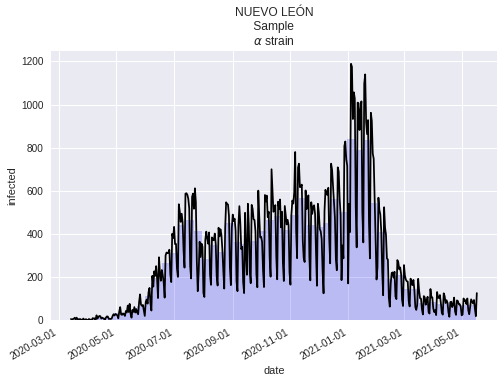

In [106]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import timedelta

# Date format
date_format = DateFormatter('%Y-%m-%d')

# Sample in date
sample_date_alpha=[]
sample_num_alpha=df_sample_alpha.tiempo.to_numpy()
for i in range(len(sample_num_alpha)):
    sample_date_alpha.append(range_dates_rt[0]+timedelta(days=int(sample_num_alpha[i])))

# Visualization
plt.style.use('seaborn')
f=plt.figure()
plt.plot_date(df_state_for_proof_alpha.Fecha,df_state_for_proof_alpha.CasosDiarios,fmt='k-')
plt.hist(sample_date_alpha,
         orientation='vertical', alpha=0.2, bins=50, color='b')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n Sample \n'+r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.savefig(ImageDir+'sample_alpha.png')
f.savefig(ImageDir+'sample_alpha.pdf')
f.set_rasterized(True)
f.savefig(ImageDir+'sample_alpha.eps',rasterized=True,dpi=300)

# Gray PNG
img = Image.open(ImageDir+'sample_alpha.png').convert('LA')
img.save(ImageDir+'sample_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'sample_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'sample_alpha_gray.eps')
plt.show()

Moreover, we show $R_t$ data and compared the two versions available

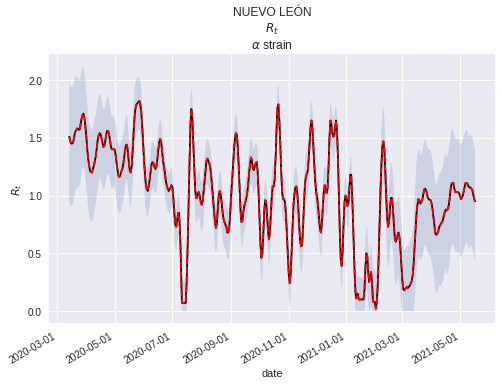

In [107]:
f=plt.figure()
plt.plot_date(df_state_for_proof_alpha.Fecha,df_state_for_proof_alpha.Rt,fmt='k-')
plt.plot_date(df_state_for_proof_alpha.Fecha,cs_rt_calculator(df_state_for_proof_alpha.index),fmt='r--')
plt.fill_between(df_state_for_proof_alpha.Fecha,cs_rt_calculator_L(df_state_for_proof_alpha.index),cs_rt_calculator_U(df_state_for_proof_alpha.index),alpha=0.2)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n'+r'$R_t$'+'\n'+r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel(r'$R_t$')
f.set_rasterized(True)
f.savefig(ImageDir+'rt_alpha.eps',rasterized=True,dpi=300)
plt.show()

### Initial conditions

We get Gompertz-Mixture parameters. First, we obtain initial conditions for EM Algorithm

In [108]:
import initial_conditions
importlib.reload(initial_conditions)
from initial_conditions import estimate_initial_parameters_risk
G = [1, 2, 3, 4]
'''
Initial conditions regression version 1
'''
data_state_alpha = df_state_for_proof_alpha.copy()
data_sample_alpha = df_sample_alpha.copy()
baseline_IC_state_for_proof_alpha= estimate_initial_parameters_risk(
    G, data_sample_alpha, data_state_alpha)
baseline_IC_state_for_proof_alpha

{0: array([-9.2851567 , -0.03923049]),
 1: array([-12.8495639 ,  -0.03983207]),
 2: array([-16.36945755,  -0.04143024]),
 3: array([-11.10430341,  -0.02011458]),
 'prob_a_priori': array([0.33847076, 0.27449051, 0.31176034, 0.0752784 ])}

In [109]:
data_sample_alpha.head()

,tiempo,Rt
0,19.0,1.56
1,27.0,1.71
2,14.0,1.45
3,17.0,1.50
4,15.0,1.45


### Estimation

First, we estimate baseline paramters for Gompertz-Mixture model, then we accelerate that model

In [110]:
import opt_baseline
importlib.reload(opt_baseline)
from opt_baseline import mgomp

'''
Preparing Initial Conditions
'''
G = len(baseline_IC_state_for_proof_alpha['prob_a_priori'])
num_parameters = 2
est_in = np.empty((G, num_parameters))
pi_in = baseline_IC_state_for_proof_alpha['prob_a_priori']

for i in range(G):
    est_in[i] = baseline_IC_state_for_proof_alpha[i]


'''
Esimation and Results
'''
NBOOT = 1
MG_baseline_alpha = mgomp(df_sample_alpha, NBOOT, est_in, pi_in, G)
MG_baseline_alpha.getest()
MG_baseline_alpha.output()

Initial parameters: 
[[ -9.2851567   -0.03923049]
 [-12.8495639   -0.03983207]
 [-16.36945755  -0.04143024]
 [-11.10430341  -0.02011458]]

Results summarize
Bootstrap= 0, Iter= 174


Component 0: gamma= -11.9756, kappa= -0.0689
Component 1: gamma= -9.0523, kappa= -0.0236
Component 2: gamma= -18.8397, kappa= -0.0498
Component 3: gamma= -10.8487, kappa= -0.0190


Mixture proportion 0: 0.1076
Mixture proportion 1: 0.4158
Mixture proportion 2: 0.3123
Mixture proportion 3: 0.1643


Obtain the coefficients of proportional hazard model

In [111]:
'''
Baseline Hazard and Cum Hazard version 1
'''
data_sample = df_sample_alpha.copy()
data_state = df_state_for_proof_alpha.copy()

days_alpha = data_state_alpha.index.to_numpy()

'''
Hazard
'''
cum_hazard_alpha, hazard_alpha= MG_baseline_alpha.hazard(days_alpha)

'''
Rt coefficients
'''
importlib.reload(initial_conditions)
from initial_conditions import estimate_parameters_Rt_cum_hazard,estimate_parameters_Rt_hazard

'''
Estimation of Rt coeficients
'''
cs_cum_hazard_par_alpha = inter_soft(days_alpha, cum_hazard_alpha, 1)
cs_hazard_par_alpha=inter_soft(days_alpha,hazard_alpha,1)
Rt_coef_hazard_alpha, labels_cum_hazard_alpha, gm_cum_hazard_alpha = estimate_parameters_Rt_hazard(
    [1], data_sample, data_state, cs_hazard_par_alpha
)
print('Los coeficientes del Rt que aceleran el riesgo acumulado son: ')
print(Rt_coef_hazard_alpha)

Los coeficientes del Rt que aceleran el riesgo acumulado son: 
[0.0271708]


### Asymptotes

Here we use HDI from $R_t$ computation to obtain asymptotes to accelerated model. 

#### Baseline $\alpha$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  218360591.62517557
zk =  [37.95443448]
f(zk) =  1738217.0734416535
|pk| =  4.983495979448565e-11
k =  7


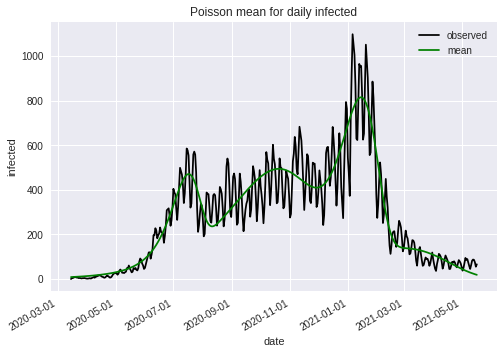

In [112]:
importlib.reload(initial_conditions)
from initial_conditions import *

# Get initial number of susceptibles
num_cum_alpha = G_sample_alpha.num_cum_mean
a_alpha=cum_hazard_alpha[1:]-cum_hazard_alpha[:-1]
a_alpha=np.concatenate(([0.0],a_alpha))
b_alpha=np.array([np.prod(1.0-a_alpha[:i+1]) for i in range(len(a_alpha))])
#b_alpha=np.concatenate(([1.0],b_alpha))

# Data for optimization
x_alpha=b_alpha[1:]-b_alpha[:-1]
y_alpha=num_cum_alpha[1:]-num_cum_alpha[:-1]
date_alpha=df_state_for_proof_alpha.Fecha.to_list()[1:]
Y0_alpha=num_cum_alpha[0]
P_alpha=pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_alpha=np.array([x_alpha,y_alpha]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_alpha,model_mean_baseline_alpha=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_alpha,P_alpha,Y0_alpha,date_alpha)

# Color EPS and PNG
f.savefig(ImageDir+'LM_alpha.png')
f.savefig(ImageDir+'LM_alpha.pdf')

f.set_rasterized(True)
f.savefig(ImageDir+'LM_alpha.eps',rasterized=True,dpi=300)


# Gray PNG
img = Image.open(ImageDir+'LM_alpha.png').convert('LA')
img.save(ImageDir+'LM_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_alpha_gray.eps')
plt.show()

#### Proportional Hazard $\alpha$

Levenberg-Marquardt algorithm CONVERGED
z0 =  2.0
f(z0) =  2074447197.4756145
zk =  [19.2892582]
f(zk) =  1722437.9170039883
|pk| =  1.4416216914144996e-09
k =  8


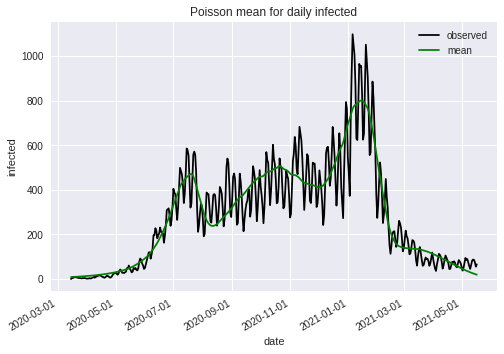

In [113]:
# Corresponding Rt
rt_acc_alpha = df_state_for_proof_alpha.Rt.to_numpy()
rt_acc_alpha = rt_acc_alpha-np.mean(rt_acc_alpha)

# Accelerated cumulative risk
cum_hazard_alpha_acc, hazard_alpha_acc=MG_baseline_alpha.hazard_acc(days_alpha,rt_acc_alpha,Rt_coef_hazard_alpha[0])
a_alpha_acc=cum_hazard_alpha_acc[1:]-cum_hazard_alpha_acc[:-1]
a_alpha_acc=np.concatenate(([0.0],a_alpha_acc))
b_alpha_acc=np.array([np.prod(1.0-a_alpha_acc[:i+1]) for i in range(len(a_alpha_acc))])
#b_alpha_acc=np.concatenate(([1.0],b_alpha_acc))

# Data for optimization
x_alpha_acc=b_alpha_acc[1:]-b_alpha_acc[:-1]
y_alpha_acc=num_cum_alpha[1:]-num_cum_alpha[:-1]
date_alpha=df_state_for_proof_alpha.Fecha.to_list()[1:]
Y0_alpha=num_cum_alpha[0]
P_alpha=pob*0.51
k0=2.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_alpha=np.array([x_alpha_acc,y_alpha_acc]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_alpha_acc, model_acc_mean_alpha=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_alpha,P_alpha,Y0_alpha,date_alpha)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_alpha_acc.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_alpha_acc.png')

# Gray PNG
img = Image.open(ImageDir+'LM_alpha_acc.png').convert('LA')
img.save(ImageDir+'LM_alpha_acc_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_alpha_acc.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_alpha_acc_gray.eps')
plt.show()

#### Accelerated Between $\alpha$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  200803002.82804847
zk =  [40.15234784]
f(zk) =  8282723.182344675
|pk| =  2.33495126240009e-10
k =  7


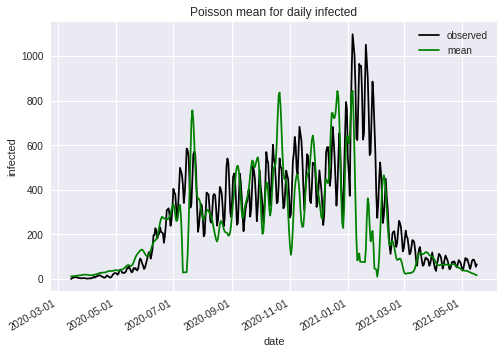

In [114]:
# Get initial number of susceptibles
num_cum_alpha = G_sample_alpha.num_cum_mean
a_alpha=cum_hazard_alpha[1:]-cum_hazard_alpha[:-1]
a_alpha=np.concatenate(([0.0],a_alpha))
b_alpha=np.array([np.prod(1.0-a_alpha[:i+1]) for i in range(len(a_alpha))])
#b_alpha=np.concatenate(([1.0],b_alpha))

# Data for optimization
x_alpha=cs_rt_calculator(days_alpha[1:])*(b_alpha[1:]-b_alpha[:-1])
y_alpha=num_cum_alpha[1:]-num_cum_alpha[:-1]
date_alpha=df_state_for_proof_alpha.Fecha.to_list()[1:]
Y0_alpha=num_cum_alpha[0]
P_alpha=pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_alpha=np.array([x_alpha,y_alpha]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_alpha_B,model_acc_mean_alpha_B=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_alpha,P_alpha,Y0_alpha,date_alpha)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_alpha_B.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_alpha_B.png')

# Gray PNG
img = Image.open(ImageDir+'LM_alpha_B.png').convert('LA')
img.save(ImageDir+'LM_alpha_B_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_alpha_B.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_alpha_B_gray.eps')
plt.show()

#### Accelerated Lower $\alpha$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  123501597.05767632
zk =  [34.81753827]
f(zk) =  11228958.85515491
|pk| =  1.8668378151836022e-11
k =  7


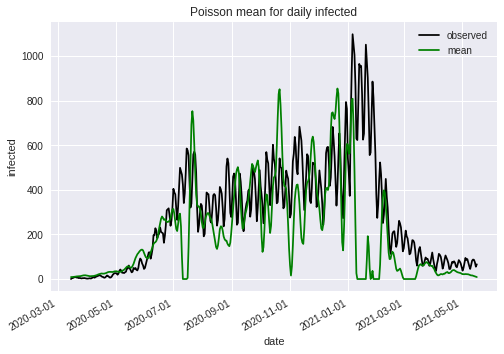

In [115]:
# Get initial number of susceptibles
num_cum_alpha = G_sample_alpha.num_cum_mean
a_alpha=cum_hazard_alpha[1:]-cum_hazard_alpha[:-1]
a_alpha=np.concatenate(([0.0],a_alpha))
b_alpha=np.array([np.prod(1.0-a_alpha[:i+1]) for i in range(len(a_alpha))])

# Data for optimization
x_alpha=cs_rt_calculator_L(days_alpha[1:])*(b_alpha[1:]-b_alpha[:-1])
y_alpha=num_cum_alpha[1:]-num_cum_alpha[:-1]
date_alpha=df_state_for_proof_alpha.Fecha.to_list()[1:]
Y0_alpha=num_cum_alpha[0]
P_alpha=pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_alpha=np.array([x_alpha,y_alpha]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_alpha_L,model_acc_mean_alpha_L=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_alpha,P_alpha,Y0_alpha,date_alpha)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_alpha_L.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_alpha_L.png')

# Gray PNG
img = Image.open(ImageDir+'LM_alpha_L.png').convert('LA')
img.save(ImageDir+'LM_alpha_L_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_alpha_L.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_alpha_L_gray.eps')
plt.show()

#### Accelerated Upper $\alpha$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  293450208.785956
zk =  [45.0915222]
f(zk) =  6125912.132060339
|pk| =  1.935288695892405e-09
k =  7


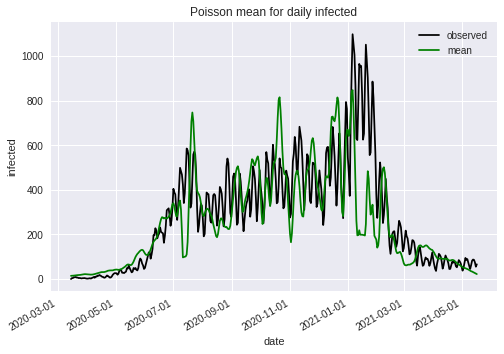

In [116]:
# Get initial number of susceptibles
num_cum_alpha = G_sample_alpha.num_cum_mean
a_alpha=cum_hazard_alpha[1:]-cum_hazard_alpha[:-1]
a_alpha=np.concatenate(([0.0],a_alpha))
b_alpha=np.array([np.prod(1.0-a_alpha[:i+1]) for i in range(len(a_alpha))])

# Data for optimization
x_alpha=cs_rt_calculator_U(days_alpha[1:])*(b_alpha[1:]-b_alpha[:-1])
y_alpha=num_cum_alpha[1:]-num_cum_alpha[:-1]
date_alpha=df_state_for_proof_alpha.Fecha.to_list()[1:]
Y0_alpha=num_cum_alpha[0]
P_alpha=pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_alpha=np.array([x_alpha,y_alpha]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_alpha_U,model_acc_mean_alpha_U=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_alpha,P_alpha,Y0_alpha,date_alpha)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_alpha_U.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_alpha_U.png')

# Gray PNG
img = Image.open(ImageDir+'LM_alpha_U.png').convert('LA')
img.save(ImageDir+'LM_alpha_U_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_alpha_U.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_alpha_U_gray.eps')
plt.show()

### Analytic Solution

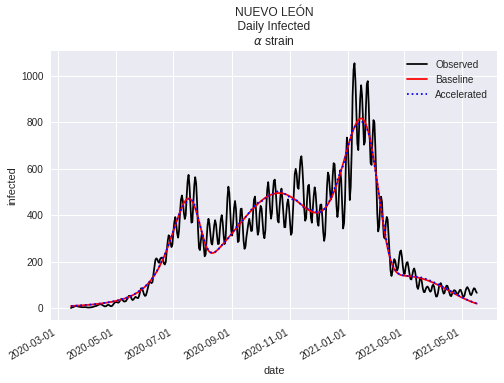

In [117]:
'''
Density alpha process
'''
from opt_baseline import mobile_mean

date_state_alpha = df_state_for_proof_alpha.Fecha.to_list()

'''
Interpolation
'''
SOFT_PAR = 3
cs_density_baseline = inter_soft(
    days_alpha[1:], model_mean_baseline_alpha, SOFT_PAR)
cs_density_acc = inter_soft(
    days_alpha[1:], model_acc_mean_alpha, SOFT_PAR)
cs_density_acc_B = inter_soft(
    days_alpha[1:], model_acc_mean_alpha_B, SOFT_PAR)
cs_density_acc_L = inter_soft(
    days_alpha[1:], model_acc_mean_alpha_L, SOFT_PAR)
cs_density_acc_U = inter_soft(
    days_alpha[1:], model_acc_mean_alpha_U, SOFT_PAR)
cs_density_obs = mobile_mean(
    days_alpha[1:], num_cum_alpha[1:]-num_cum_alpha[:-1], M_MEAN)

'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_state_alpha[1:], cs_density_obs(
    days_alpha[1:]), fmt='k-', label='Observed')
plt.plot_date(date_state_alpha[1:], cs_density_baseline(days_alpha[1:]), fmt='r-', label='Baseline')
plt.plot_date(date_state_alpha[1:], cs_density_acc(days_alpha[1:]), fmt='b:', label='Accelerated')
#plt.plot_date(date_state_alpha[1:], cs_density_acc_B(days_alpha[1:]), fmt='-.g', label='Between')
#plt.plot_date(date_state_alpha[1:], cs_density_acc_L(days_alpha[1:]), fmt='-.g', label='Lower')
#plt.plot_date(date_state_alpha[1:], cs_density_acc_U(days_alpha[1:]), fmt='-.g', label='Upper')
#plt.fill_between(pd.to_datetime(pd.Series(date_state_alpha[1:])),cs_density_acc_L(days_alpha[1:]),cs_density_acc_U(days_alpha[1:]),alpha=0.2)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.savefig(ImageDir+'density_alpha.png')
f.savefig(ImageDir+'density_alpha.pdf')

f.set_rasterized(True)
f.savefig(ImageDir+'density_alpha.eps',rasterized=True,dpi=300)


# Gray PNG
img = Image.open(ImageDir+'density_alpha.png').convert('LA')
img.save(ImageDir+'density_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_alpha_gray.eps')
plt.show()

### Simulation

#### Baseline

In [118]:
from scipy.stats import poisson
'''
Poisson process baseline model
'''
k_alpha=np.squeeze(dic_results_asym_alpha['zk'])
# Poisson process
X_baseline_alpha = np.empty(len(days_alpha))
A_baseline_alpha = np.empty(len(days_alpha))
X_baseline_alpha[0] = num_cum_alpha[0]
A_baseline_alpha[0] = X_baseline_alpha[0]
for i in range(1, len(X_baseline_alpha)):
    if i <= len(num_cum_alpha)-1:
        mu_est = (P_alpha/k_alpha-A_baseline_alpha[i-1]) * \
            (cum_hazard_alpha[i]-cum_hazard_alpha[i-1])
    else:
        mu_est = (num_cum_alpha[0])*(cum_hazard_alpha[i]-cum_hazard_alpha[i-1])
    X_baseline_alpha[i] = poisson.rvs(mu=mu_est)
    A_baseline_alpha[i] = A_baseline_alpha[i-1]+X_baseline_alpha[i]


#### Proportional hazard

In [119]:
'''
Poisson process other accelerated model
'''
rt_alpha_updated = cs_rt_calculator(days_alpha)
k_alpha=np.squeeze(dic_results_asym_alpha['zk'])

# Poisson process
X_acc_mean_alpha = np.empty(len(days_alpha))
A_acc_mean_alpha = np.empty(len(days_alpha))
X_acc_mean_alpha[0] = num_cum_alpha[0]
A_acc_mean_alpha[0] = X_acc_mean_alpha[0]
for i in range(1, len(X_acc_mean_alpha)):
    if i <= len(num_cum_alpha)-1:
        mu_est = np.exp(rt_alpha_updated[i-1]/12)*(P_alpha/k_alpha-A_acc_mean_alpha[i-1]) * \
            (cum_hazard_alpha[i]-cum_hazard_alpha[i-1])
    else:
        mu_est = (num_cum_alpha[0])*(cum_hazard_alpha[i]-cum_hazard_alpha[i-1])
    X_acc_mean_alpha[i] = poisson.rvs(mu=mu_est)
    A_acc_mean_alpha[i] = A_acc_mean_alpha[i-1]+X_acc_mean_alpha[i]

### Simulation Results

Throughout simulation we obtain the growth curve and density for $\alpha$ process

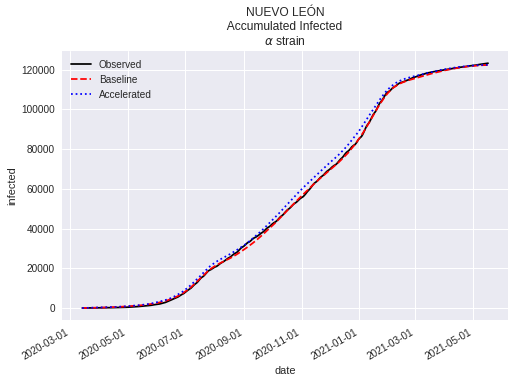

In [120]:
'''
Growth model alpha process
'''

date_state_alpha = df_state_for_proof_alpha.Fecha.to_list()

f=plt.figure()
plt.plot_date(date_state_alpha, num_cum_alpha, fmt='-k', label='Observed')
plt.plot_date(date_state_alpha, A_baseline_alpha, fmt='--r',label='Baseline')
plt.plot_date(date_state_alpha, A_acc_mean_alpha, fmt=':b', label='Accelerated')


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')

f.savefig(ImageDir+'accumulated_alpha.png')
f.savefig(ImageDir+'accumulated_alpha.pdf')

f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_alpha.eps',rasterized=True,dpi=300)


img = Image.open(ImageDir+'accumulated_alpha.png').convert('LA')
img.save(ImageDir+'accumulated_alpha_gray.png')
img = Image.open(ImageDir+'accumulated_alpha.eps')
img.convert("L").save(ImageDir+'accumulated_alpha_gray.eps')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_alpha.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_alpha.png')

# Gray PNG
img = Image.open(ImageDir+'accumulated_alpha.png').convert('LA')
img.save(ImageDir+'accumulated_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'accumulated_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'accumulated_alpha_gray.eps')
plt.show()

The density is

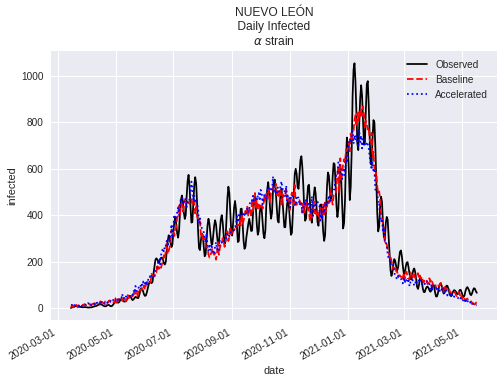

In [121]:
'''
Density alpha process
'''
from opt_baseline import mobile_mean
'''
Interpolation
'''
SOFT_PAR = 1
cs_density_baseline = inter_soft(
    days_alpha[1:], A_baseline_alpha[1:]-A_baseline_alpha[:-1], SOFT_PAR)
cs_density_acc = inter_soft(
    days_alpha[1:], A_acc_mean_alpha[1:]-A_acc_mean_alpha[:-1], SOFT_PAR)
cs_density_obs = mobile_mean(
    days_alpha[1:], num_cum_alpha[1:]-num_cum_alpha[:-1], M_MEAN)

'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_state_alpha[1:], cs_density_obs(
    days_alpha[1:]), fmt='k-', label='Observed')
plt.plot_date(date_state_alpha[1:], cs_density_baseline(
    days_alpha[1:]), fmt='r--', label='Baseline')
plt.plot_date(date_state_alpha[1:], cs_density_acc(days_alpha[1:]), fmt='b:', label='Accelerated')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_alpha.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_alpha.png')

# Gray PNG
img = Image.open(ImageDir+'density_alpha.png').convert('LA')
img.save(ImageDir+'density_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_alpha_gray.eps')
plt.show()

### Negative Binomial Regression

We add $R_t$ variable assuming that baseline model provides a plausible estimation of mean number of infected. This framerworks attempts to add dispersion to our first estimation.

In [122]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = "Y ~ log_Rt"
rt_alpha_GLM=cs_rt_calculator(days_alpha[1:])+0.01
log_model_mean_alpha_GLM=np.log(cs_density_baseline(days_alpha[1:])+1)


data_Reg_alpha=pd.DataFrame({'Y': num_cum_alpha[1:]-num_cum_alpha[:-1],'log_baseline_mean':log_model_mean_alpha_GLM,'log_Rt':np.log(rt_alpha_GLM)})
model_alpha = smf.glm(formula=formula, data=data_Reg_alpha,offset=log_model_mean_alpha_GLM,family=sm.families.NegativeBinomial()).fit(scale='dev')
print(model_alpha.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                  429
Model:                            GLM   Df Residuals:                      427
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                         0.20759
Method:                          IRLS   Log-Likelihood:                -12739.
Date:                Sat, 10 Dec 2022   Deviance:                       88.643
Time:                        19:44:05   Pearson chi2:                     99.4
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0026      0.023      0.116      0.9

### Visualization

We construct confidence bands for density curve (daily infected curve) using Negative Binomial GLM model

In [123]:
from scipy.stats import norm
''' 
Necessary elements 
'''
X_alpha=np.column_stack([np.ones(len(rt_alpha_GLM)),np.log(rt_alpha_GLM)])
var_coeff=model_alpha.cov_params()
'''
Variance Linear Predictor
'''
var_lin_pred_alpha=np.array([np.squeeze(X_alpha[i,:].reshape(1,-1)@var_coeff@X_alpha[i,:].reshape(1,-1).T) for i in range(X_alpha.shape[0])])
se_lin_pred_alpha=np.sqrt(var_lin_pred_alpha)
beta_alpha=np.asarray(model_alpha.params).reshape(-1,1)
lin_pred_alpha=np.squeeze(X_alpha@beta_alpha)+log_model_mean_alpha_GLM
''' 
Wald Interval Linear Predictor
'''
level_band=0.01
z_a=norm.ppf(1-level_band/2)
conf_band_alpha_lin_pred_L=lin_pred_alpha-z_a*se_lin_pred_alpha
conf_band_alpha_lin_pred_U=lin_pred_alpha+z_a*se_lin_pred_alpha

'''
Wald Interval for mean
'''
M_MEAN_CI=5
cs_model_alpha=mobile_mean(days_alpha[1:],model_alpha.mu,M_MEAN_CI)
conf_band_alpha_mean_L=np.exp(conf_band_alpha_lin_pred_L)
cs_conf_band_alpha_mean_L=mobile_mean(days_alpha[1:],conf_band_alpha_mean_L,M_MEAN_CI)
conf_band_alpha_mean_U=np.exp(conf_band_alpha_lin_pred_U)
cs_conf_band_alpha_mean_U=mobile_mean(days_alpha[1:],conf_band_alpha_mean_U,M_MEAN_CI)

Here we present the adjustment density

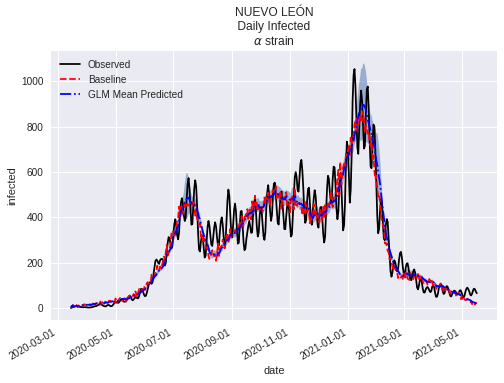

In [124]:
'''
Results for GLM model with Cox Baseline Process
'''
f=plt.figure()
plt.plot_date(date_state_alpha[1:], cs_density_obs(
    days_alpha[1:]), fmt='k-', label='Observed')
plt.plot_date(date_state_alpha[1:], cs_density_baseline(days_alpha[1:]), fmt='r--', label='Baseline')
plt.plot_date(date_state_alpha[1:],cs_model_alpha(days_alpha[1:]),label='GLM Mean Predicted',fmt='b-.')
plt.fill_between(pd.to_datetime(pd.Series(date_state_alpha[1:])),cs_conf_band_alpha_mean_L(days_alpha[1:]),cs_conf_band_alpha_mean_U(days_alpha[1:]),alpha=0.5)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_GLM_alpha.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_GLM_alpha.png')

# Gray PNG
img = Image.open(ImageDir+'density_GLM_alpha.png').convert('LA')
img.save(ImageDir+'density_GLM_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_GLM_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_GLM_alpha_gray.eps')
plt.show()

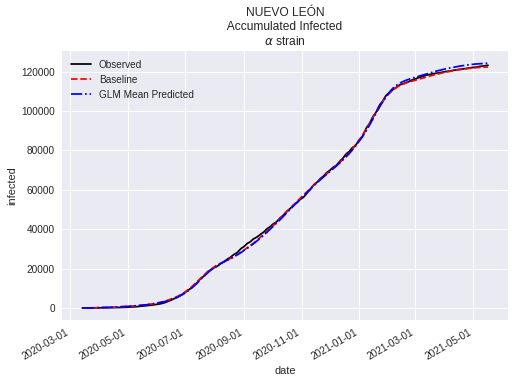

In [125]:
'''
Growth model throughout GLM model
'''
f=plt.figure()
#plt.fill_between(data_state_alpha,A_acc_mean_alpha_L,A_acc_mean_alpha_U,alpha=0.5)
plt.plot_date(date_state_alpha, num_cum_alpha, fmt='-k', label='Observed')
plt.plot_date(date_state_alpha[1:], np.cumsum(cs_density_baseline(days_alpha[1:])), fmt='r--', label='Baseline')
plt.plot_date(date_state_alpha[1:],np.cumsum(cs_model_alpha(days_alpha[1:])),label='GLM Mean Predicted',fmt='b-.')
#plt.fill_between(pd.to_datetime(pd.Series(date_state_alpha[1:])),np.cumsum(cs_conf_band_alpha_mean_L(days_alpha[1:])),np.cumsum(cs_conf_band_alpha_mean_U(days_alpha[1:])),alpha=0.3)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_GLM_alpha.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_GLM_alpha.png',rasterized=True,dpi=300)
img = Image.open(ImageDir+'accumulated_GLM_alpha.png').convert('LA')
img.save(ImageDir+'accumulated_GLM_alpha_gray.png')
img = Image.open(ImageDir+'accumulated_GLM_alpha.eps')
img.convert("L").save(ImageDir+'accumulated_GLM_alpha_gray.eps')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_GLM_alpha.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_GLM_alpha.png')

# Gray PNG
img = Image.open(ImageDir+'accumulated_GLM_alpha.png').convert('LA')
img.save(ImageDir+'accumulated_GLM_alpha_gray.png')

# Gray EPS
img = Image.open(ImageDir+'accumulated_GLM_alpha.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'accumulated_GLM_alpha_gray.eps')
plt.show()

We use mean poisson deviance in order to measure the error

In [126]:
from sklearn.metrics import mean_poisson_deviance

deviance_error_baseline_alpha=mean_poisson_deviance(G_sample_alpha.num_dia_mean,X_baseline_alpha)
deviance_error_GLM_alpha=mean_poisson_deviance(G_sample_alpha.num_dia_mean[1:],model_acc_mean_alpha)
deviance_error_acc_alpha=mean_poisson_deviance(G_sample_alpha.num_dia_mean,X_acc_mean_alpha)
print('deviance alpha baseline : %.4f' %(deviance_error_baseline_alpha))
print('deviance alpha proportional hazard: %.4f' %(deviance_error_GLM_alpha))
print('deviance alpha GLM: %.4f' %(deviance_error_acc_alpha))

deviance alpha baseline : 22.2475
deviance alpha proportional hazard: 21.7273
deviance alpha GLM: 25.6073


## $\Delta$ process 

We get $\Delta$ database

In [127]:
# delta data base
df_state_for_proof_delta=df_state_for_proof[(df_state_for_proof.Fecha>=range_cepas_dates[1]) & (df_state_for_proof.Fecha<=range_cepas_dates[2])]
df_state_for_proof_delta['Rt']=cs_rt_calculator(df_state_for_proof_delta.index.to_numpy())

# scale variables
'''
Accumulated data for delta strain
'''
last_num_cum_alpha=df_state_for_proof_alpha.CasosAcumulados.to_list()[-1]
df_state_for_proof_delta.CasosAcumulados=df_state_for_proof_delta.CasosAcumulados.to_numpy()-last_num_cum_alpha

'''
Restart time
'''
df_state_for_proof_delta.index=df_state_for_proof_delta.index.to_numpy()-num_delta_rt_begin
df_state_for_proof_delta.tail()

,Fecha,CasosAcumulados,CasosDiarios,Rt
215.0,2021-12-19,86354.0,26.0,2.20
216.0,2021-12-20,86465.0,111.0,2.54
217.0,2021-12-21,86546.0,81.0,2.73
218.0,2021-12-22,86645.0,99.0,2.73
219.0,2021-12-23,86755.0,110.0,10.00


### Sampling

We get the sample from `CasosAcumulados/CasosDiarios` data.

In [128]:
import samples
importlib.reload(samples)
SAMPLES = 20
M_MEAN = 3
from samples import g_sample
SamplesDir = DataDir+'Samples/'
'''
delta sample
'''
G_sample_delta=g_sample(df_state_for_proof_delta,SamplesDir+state_for_proof+'_delta.csv',SAMPLES,M_MEAN)
G_sample_delta.main()
df_sample_delta=G_sample_delta.get_sampling_data()
df_sample_delta['Rt']=cs_rt_calculator(df_sample_delta.tiempo.to_numpy()+num_delta_rt_begin)

We show the sample against `CasosDiarios`

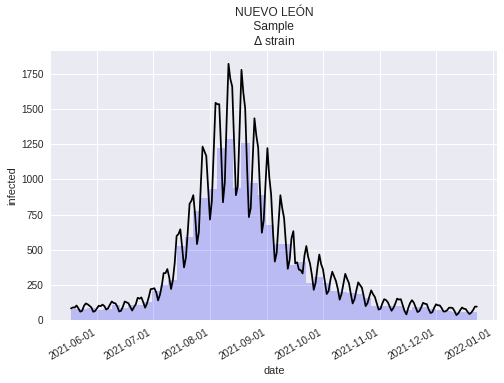

In [129]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import timedelta

# Date format
date_format = DateFormatter('%Y-%m-%d')

# Sample in date
sample_date_delta=[]
sample_num_delta=df_sample_delta.tiempo.to_numpy()
for i in range(len(sample_num_delta)):
    sample_date_delta.append(range_cepas_dates[1]+timedelta(days=int(sample_num_delta[i])))

# Visualization
plt.style.use('seaborn')
f=plt.figure()
plt.plot_date(df_state_for_proof_delta.Fecha,G_sample_delta.num_dia_mean,fmt='k-')
plt.hist(sample_date_delta,
         orientation='vertical', alpha=0.2, bins=50, color='b')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n Sample \n'+r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'sample_delta.png')
f.savefig(ImageDir+'sample_delta.pdf')
f.savefig(ImageDir+'sample_delta.eps',rasterized=True,dpi=300)


# Gray PNG
img = Image.open(ImageDir+'sample_delta.png').convert('LA')
img.save(ImageDir+'sample_delta_gray.png')

# Gray EPS
img = Image.open(ImageDir+'sample_delta.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'sample_delta_gray.eps')
plt.show()

$R_t$ visualization for delta strain

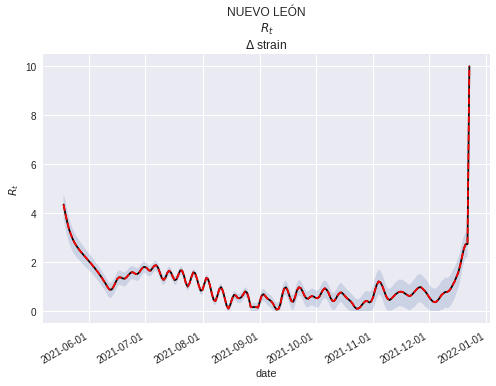

In [130]:
f=plt.figure()
plt.plot_date(df_state_for_proof_delta.Fecha,df_state_for_proof_delta.Rt,fmt='k-')
plt.plot_date(df_state_for_proof_delta.Fecha,cs_rt_calculator(df_state_for_proof_delta.index+num_delta_rt_begin),fmt='r--')
plt.fill_between(df_state_for_proof_delta.Fecha,cs_rt_calculator_L(df_state_for_proof_delta.index+num_delta_rt_begin),cs_rt_calculator_U(df_state_for_proof_delta.index+num_delta_rt_begin),alpha=0.2)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n'+r'$R_t$'+'\n'+r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel(r'$R_t$')
f.set_rasterized(True)
f.savefig(ImageDir+'rt_delta.eps',rasterized=True,dpi=300)
plt.show()

### Initial conditions

We get initial condition for iterative estimation using the last sample

In [131]:
import initial_conditions
importlib.reload(initial_conditions)
from initial_conditions import estimate_initial_parameters_risk
G = [1, 2, 3, 4]
'''
Initial conditions regression version 1
'''
data_state_delta = df_state_for_proof_delta.copy()
data_sample_delta = df_sample_delta.copy()
baseline_IC_state_for_proof_delta= estimate_initial_parameters_risk(
    G, data_sample_delta, data_state_delta)
baseline_IC_state_for_proof_delta

{0: array([-6.19031698, -0.08545499]),
 1: array([-9.2429451 , -0.07344702]),
 2: array([-7.98776526, -0.04041922]),
 3: array([-10.040997  ,  -0.03752833]),
 'prob_a_priori': array([0.20217263, 0.53480834, 0.08611336, 0.17690567])}

### Estimation
We estimate Gompertz-Mixture parameters for $\Delta$ process

In [132]:
import opt_baseline
importlib.reload(opt_baseline)
from opt_baseline import mgomp

'''
Preparing Initial Conditions
'''
G = len(baseline_IC_state_for_proof_delta['prob_a_priori'])
num_parameters = 2
est_in = np.empty((G, num_parameters))
pi_in = baseline_IC_state_for_proof_delta['prob_a_priori']

for i in range(G):
    est_in[i] = baseline_IC_state_for_proof_delta[i]

'''
Esimation and Results
'''
NBOOT = 1
MG_baseline_delta = mgomp(df_sample_delta, NBOOT, est_in, pi_in, G)
MG_baseline_delta.getest()
MG_baseline_delta.output()

Initial parameters: 
[[ -6.19031698  -0.08545499]
 [ -9.2429451   -0.07344702]
 [ -7.98776526  -0.04041922]
 [-10.040997    -0.03752833]]

Results summarize
Bootstrap= 0, Iter= 345


Component 0: gamma= -2.9929, kappa= -0.0654
Component 1: gamma= -8.3946, kappa= -0.0636
Component 2: gamma= -7.6772, kappa= -0.0366
Component 3: gamma= -10.6100, kappa= -0.0402


Mixture proportion 0: 0.0132
Mixture proportion 1: 0.5599
Mixture proportion 2: 0.3371
Mixture proportion 3: 0.0898


Afterwards, we accelerate baseline model

In [133]:
'''
Baseline Hazard and Cum Hazard version 1
'''
data_sample = df_sample_delta.copy()
data_state = df_state_for_proof_delta.copy()

days_delta = data_state_delta.index.to_numpy()
cum_hazard_delta, hazard_delta= MG_baseline_delta.hazard(days_delta)

'''
Rt coefficients
'''
importlib.reload(initial_conditions)
from initial_conditions import estimate_parameters_Rt_cum_hazard,estimate_parameters_Rt_hazard

'''
Estimation of Rt coeficients
'''
cs_cum_hazard_par_delta = inter_soft(days_delta, cum_hazard_delta, 1)
cs_hazard_par_delta=inter_soft(days_delta,hazard_delta,1)
Rt_coef_hazard_delta, labels_cum_hazard_delta, gm_cum_hazard_delta = estimate_parameters_Rt_hazard(
    [1], data_sample, data_state, cs_hazard_par_delta
)
print('Los coeficientes del Rt que aceleran el riesgo acumulado son: ')
print(Rt_coef_hazard_delta)

Los coeficientes del Rt que aceleran el riesgo acumulado son: 
[0.07449982]


### Asymptotes

Here we use HDI from $R_t$ computation to obtain asymptotes to accelerated model. 

#### Baseline $\Delta$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  670641356.061028
zk =  [53.82381319]
f(zk) =  2300017.8909508702
|pk| =  1.63534906464897e-11
k =  8


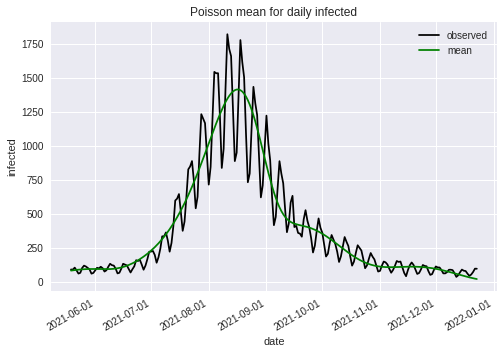

In [134]:
importlib.reload(initial_conditions)
from initial_conditions import *

# Get initial number of susceptibles
num_cum_delta = G_sample_delta.num_cum_mean
a_delta=cum_hazard_delta[1:]-cum_hazard_delta[:-1]
a_delta=np.concatenate(([0.0],a_delta))
b_delta=np.array([np.prod(1.0-a_delta[:i+1]) for i in range(len(a_delta))])
#b_delta=np.concatenate(([1.0],b_delta))

# Data for optimization
x_delta=b_delta[1:]-b_delta[:-1]
y_delta=num_cum_delta[1:]-num_cum_delta[:-1]
date_delta=df_state_for_proof_delta.Fecha.to_list()[1:]
Y0_delta=num_cum_delta[0]
P_delta=pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_delta=np.array([x_delta,y_delta]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_delta,model_mean_baseline_delta=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_delta,P_delta,Y0_delta,date_delta)

# Color EPS and PNG
f.savefig(ImageDir+'LM_delta.png')
f.savefig(ImageDir+'LM_delta.pdf')

f.set_rasterized(True)
f.savefig(ImageDir+'LM_delta.eps',rasterized=True,dpi=300)


# Gray PNG
img = Image.open(ImageDir+'LM_delta.png').convert('LA')
img.save(ImageDir+'LM_delta_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_delta.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_delta_gray.eps')
plt.show()

#### Proportional Hazard $\Delta$

Levenberg-Marquardt algorithm CONVERGED
z0 =  2.0
f(z0) =  5403162558.60087
zk =  [26.8570125]
f(zk) =  2133360.2943966575
|pk| =  6.509363542874793e-11
k =  9


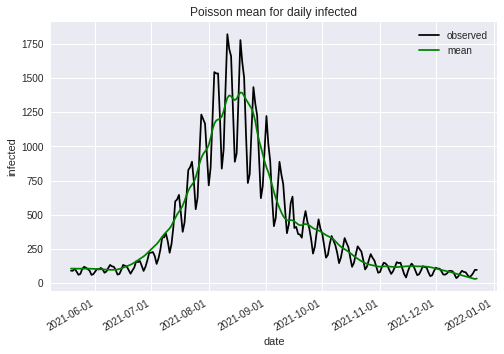

In [135]:
# Corresponding Rt
rt_acc_delta = df_state_for_proof_delta.Rt.to_numpy()
rt_acc_delta = rt_acc_delta-np.mean(rt_acc_delta)

# Accelerated cumulative risk
cum_hazard_delta_acc, hazard_delta_acc=MG_baseline_delta.hazard_acc(days_delta,rt_acc_delta,Rt_coef_hazard_delta[0])
a_delta_acc=cum_hazard_delta_acc[1:]-cum_hazard_delta_acc[:-1]
a_delta_acc=np.concatenate(([0.0],a_delta_acc))
b_delta_acc=np.array([np.prod(1.0-a_delta_acc[:i+1]) for i in range(len(a_delta_acc))])
#b_delta_acc=np.concatenate(([1.0],b_delta_acc))

# Data for optimization
x_delta_acc=b_delta_acc[1:]-b_delta_acc[:-1]
y_delta_acc=num_cum_delta[1:]-num_cum_delta[:-1]
date_delta=df_state_for_proof_delta.Fecha.to_list()[1:]
Y0_delta=num_cum_delta[0]
P_delta=pob*0.51
k0=2.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_delta=np.array([x_delta_acc,y_delta_acc]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_delta_acc, model_acc_mean_delta=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_delta,P_delta,Y0_delta,date_delta)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_delta_acc.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_delta_acc.png')

# Gray PNG
img = Image.open(ImageDir+'LM_delta_acc.png').convert('LA')
img.save(ImageDir+'LM_delta_acc_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_delta_acc.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_delta_acc_gray.eps')
plt.show()

#### Accelerated Between $\Delta$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  72785603.99441923
zk =  [24.99915981]
f(zk) =  8514908.270257866
|pk| =  7.414696793434192e-11
k =  6


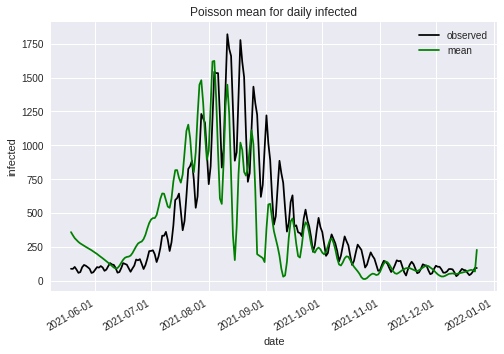

In [136]:
# Get initial number of susceptibles
num_cum_delta = G_sample_delta.num_cum_mean
a_delta=cum_hazard_delta[1:]-cum_hazard_delta[:-1]
a_delta=np.concatenate(([0.0],a_delta))
b_delta=np.array([np.prod(1.0-a_delta[:i+1]) for i in range(len(a_delta))])
#b_delta=np.concatenate(([1.0],b_delta))

# Data for optimization
x_delta=cs_rt_calculator(days_delta[1:]+num_delta_rt_begin)*(b_delta[1:]-b_delta[:-1])
y_delta=num_cum_delta[1:]-num_cum_delta[:-1]
date_delta=df_state_for_proof_delta.Fecha.to_list()[1:]
Y0_delta=num_cum_delta[0]
P_delta=pob*0.51
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_delta=np.array([x_delta,y_delta]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_delta_B,model_acc_mean_delta_B=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_delta,P_delta,Y0_delta,date_delta)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_delta_B.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_delta_B.png')

# Gray PNG
img = Image.open(ImageDir+'LM_delta_B.png').convert('LA')
img.save(ImageDir+'LM_delta_B_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_delta_B.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_delta_B_gray.eps')
plt.show()

#### Accelerated Lower $\Delta$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  46592495.16760026
zk =  [21.81626867]
f(zk) =  13035978.29423314
|pk| =  2.6853140313985477e-12
k =  6


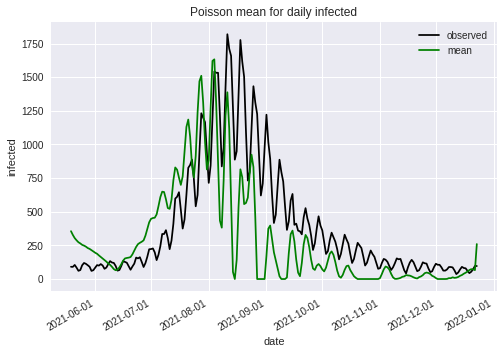

In [137]:
# Get initial number of susceptibles
num_cum_delta = G_sample_delta.num_cum_mean
a_delta=cum_hazard_delta[1:]-cum_hazard_delta[:-1]
a_delta=np.concatenate(([0.0],a_delta))
b_delta=np.array([np.prod(1.0-a_delta[:i+1]) for i in range(len(a_delta))])

# Data for optimization
x_delta=cs_rt_calculator_L(days_delta[1:]+num_delta_rt_begin)*(b_delta[1:]-b_delta[:-1])
y_delta=num_cum_delta[1:]-num_cum_delta[:-1]
date_delta=df_state_for_proof_delta.Fecha.to_list()[1:]
Y0_delta=num_cum_delta[0]
P_delta=pob*0.51
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_delta=np.array([x_delta,y_delta]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_delta_L,model_acc_mean_delta_L=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_delta,P_delta,Y0_delta,date_delta)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_delta_L.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_delta_L.png')

# Gray PNG
img = Image.open(ImageDir+'LM_delta_L.png').convert('LA')
img.save(ImageDir+'LM_delta_L_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_delta_L.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_delta_L_gray.eps')
plt.show()

#### Accelerated Upper $\Delta$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  653808844.2384918
zk =  [55.82346341]
f(zk) =  6255488.114141592
|pk| =  4.1939958793504075e-11
k =  8


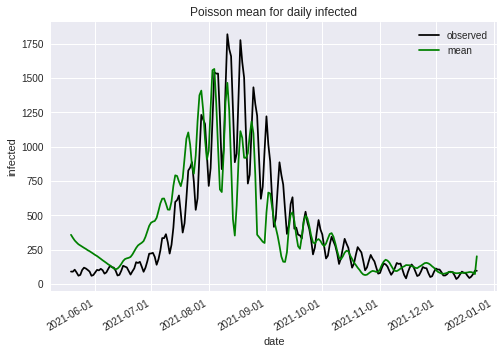

In [138]:
# Get initial number of susceptibles
num_cum_delta = G_sample_delta.num_cum_mean
a_delta=cum_hazard_delta[1:]-cum_hazard_delta[:-1]
a_delta=np.concatenate(([0.0],a_delta))
b_delta=np.array([np.prod(1.0-a_delta[:i+1]) for i in range(len(a_delta))])

# Data for optimization
x_delta=cs_rt_calculator_U(days_delta[1:]+num_delta_rt_begin)*(b_delta[1:]-b_delta[:-1])
y_delta=num_cum_delta[1:]-num_cum_delta[:-1]
date_delta=df_state_for_proof_delta.Fecha.to_list()[1:]
Y0_delta=num_cum_delta[0]
P_delta=pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_delta=np.array([x_delta,y_delta]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_delta_U,model_acc_mean_delta_U=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_delta,P_delta,Y0_delta,date_delta)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_delta_U.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_delta_U.png')

# Gray PNG
img = Image.open(ImageDir+'LM_delta_U.png').convert('LA')
img.save(ImageDir+'LM_delta_U_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_delta_U.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_delta_U_gray.eps')
plt.show()

### Analytic Solution

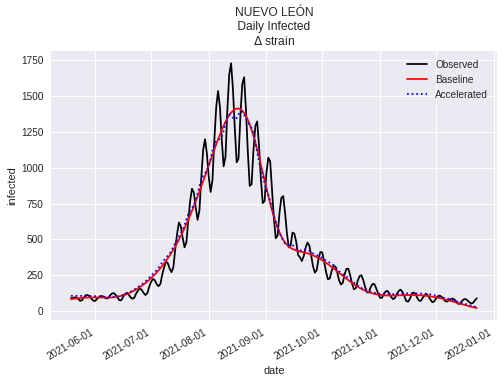

In [139]:
'''
Density delta process
'''
from opt_baseline import mobile_mean

date_state_delta = df_state_for_proof_delta.Fecha.to_list()

'''
Interpolation
'''
SOFT_PAR = 1
cs_density_baseline = inter_soft(
    days_delta[1:], model_mean_baseline_delta, SOFT_PAR)
cs_density_acc = inter_soft(
    days_delta[1:], model_acc_mean_delta, SOFT_PAR)
cs_density_acc_B = inter_soft(
    days_delta[1:], model_acc_mean_delta_B, SOFT_PAR)
cs_density_acc_L = inter_soft(
    days_delta[1:], model_acc_mean_delta_L, SOFT_PAR)
cs_density_acc_U = inter_soft(
    days_delta[1:], model_acc_mean_delta_U, SOFT_PAR)
cs_density_obs = mobile_mean(
    days_delta[1:], num_cum_delta[1:]-num_cum_delta[:-1], M_MEAN)

'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_state_delta[1:], cs_density_obs(
    days_delta[1:]), fmt='k-', label='Observed')
plt.plot_date(date_state_delta[1:], cs_density_baseline(days_delta[1:]), fmt='r-', label='Baseline')
plt.plot_date(date_state_delta[1:], cs_density_acc(days_delta[1:]), fmt='b:', label='Accelerated')
#plt.plot_date(date_state_delta[1:], cs_density_acc_B(days_delta[1:]), fmt='-.g', label='Between')
#plt.plot_date(date_state_delta[1:], cs_density_acc_L(days_delta[1:]), fmt='-.g', label='Lower')
#plt.plot_date(date_state_delta[1:], cs_density_acc_U(days_delta[1:]), fmt='-.g', label='Upper')
#plt.fill_between(pd.to_datetime(pd.Series(date_state_delta[1:])),cs_density_acc_L(days_delta[1:]),cs_density_acc_U(days_delta[1:]),delta=0.2)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.savefig(ImageDir+'density_delta.png')
f.savefig(ImageDir+'density_delta.pdf')

f.set_rasterized(True)
f.savefig(ImageDir+'density_delta.eps',rasterized=True,dpi=300)


# Gray PNG
img = Image.open(ImageDir+'density_delta.png').convert('LA')
img.save(ImageDir+'density_delta_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_delta.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_delta_gray.eps')
plt.show()

### Simulation

#### Baseline

In [140]:
from scipy.stats import poisson
'''
Poisson process baseline model
'''
k_delta=np.squeeze(dic_results_asym_delta['zk'])
# Poisson process
X_baseline_delta = np.empty(len(days_delta))
A_baseline_delta = np.empty(len(days_delta))
X_baseline_delta[0] = num_cum_delta[0]
A_baseline_delta[0] = X_baseline_delta[0]
for i in range(1, len(X_baseline_delta)):
    if i <= len(num_cum_delta)-1:
        mu_est = (P_delta/k_delta-A_baseline_delta[i-1]) * \
            (cum_hazard_delta[i]-cum_hazard_delta[i-1])
    else:
        mu_est = (num_cum_delta[0])*(cum_hazard_delta[i]-cum_hazard_delta[i-1])
    X_baseline_delta[i] = poisson.rvs(mu=mu_est)
    A_baseline_delta[i] = A_baseline_delta[i-1]+X_baseline_delta[i]

#### Proportional Hazard

In [141]:
'''
Poisson process other accelerated model
'''
rt_delta_updated = cs_rt_calculator(days_delta+num_delta_rt_begin)
k_delta=np.squeeze(dic_results_asym_delta['zk'])

# Poisson process
X_acc_mean_delta = np.empty(len(days_delta))
A_acc_mean_delta = np.empty(len(days_delta))
X_acc_mean_delta[0] = num_cum_delta[0]
A_acc_mean_delta[0] = X_acc_mean_delta[0]
for i in range(1, len(X_acc_mean_delta)):
    if i <= len(num_cum_delta)-1:
        mu_est = np.exp(rt_delta_updated[i-1]/12)*(P_delta/k_delta-A_acc_mean_delta[i-1]) * \
            (cum_hazard_delta[i]-cum_hazard_delta[i-1])
    else:
        mu_est = (num_cum_delta[0])*(cum_hazard_delta[i]-cum_hazard_delta[i-1])
    X_acc_mean_delta[i] = poisson.rvs(mu=mu_est)
    A_acc_mean_delta[i] = A_acc_mean_delta[i-1]+X_acc_mean_delta[i]

### Simulation Results

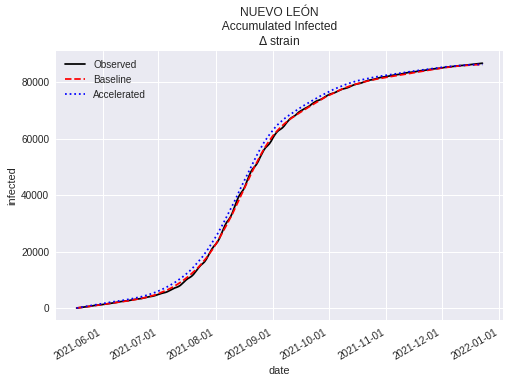

In [142]:
'''
Growth model delta process
'''

date_state_delta = df_state_for_proof_delta.Fecha.to_list()

f=plt.figure()
plt.plot_date(date_state_delta, num_cum_delta, fmt='-k', label='Observed')
plt.plot_date(date_state_delta, A_baseline_delta, fmt='--r',label='Baseline')
plt.plot_date(date_state_delta, A_acc_mean_delta, fmt=':b', label='Accelerated')


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel('infected')

f.savefig(ImageDir+'accumulated_delta.png')
f.savefig(ImageDir+'accumulated_delta.pdf')
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_delta.eps',rasterized=True,dpi=300)

img = Image.open(ImageDir+'accumulated_delta.png').convert('LA')
img.save(ImageDir+'accumulated_delta_gray.png')
img = Image.open(ImageDir+'accumulated_delta.eps')
img.convert("L").save(ImageDir+'accumulated_delta_gray.eps')

The density is

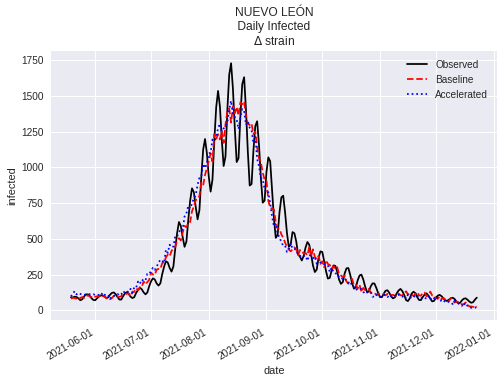

In [143]:
'''
Density delta process
'''
from opt_baseline import mobile_mean
'''
Interpolation
'''
SOFT_PAR = 1
cs_density_baseline = inter_soft(
    days_delta[1:], A_baseline_delta[1:]-A_baseline_delta[:-1], SOFT_PAR)
cs_density_acc = inter_soft(
    days_delta[1:], A_acc_mean_delta[1:]-A_acc_mean_delta[:-1], SOFT_PAR)
cs_density_obs = mobile_mean(
    days_delta[1:], num_cum_delta[1:]-num_cum_delta[:-1], M_MEAN)

'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_state_delta[1:], cs_density_obs(
    days_delta[1:]), fmt='k-', label='Observed')
plt.plot_date(date_state_delta[1:], cs_density_baseline(
    days_delta[1:]), fmt='r--', label='Baseline')
plt.plot_date(date_state_delta[1:], cs_density_acc(days_delta[1:]), fmt='b:', label='Accelerated')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_delta.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_delta.png')

# Gray PNG
img = Image.open(ImageDir+'density_delta.png').convert('LA')
img.save(ImageDir+'density_delta_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_delta.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_delta_gray.eps')
plt.show()

### Negative Binomial Regression

In [144]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = "Y ~ log_Rt"
rt_delta_GLM=cs_rt_delta(days_delta[1:]+num_delta_rt_begin)+0.01
log_model_mean_delta_GLM=np.log(cs_density_baseline(days_delta[1:])+1)

data_Reg_delta=pd.DataFrame({'Y': num_cum_delta[1:]-num_cum_delta[:-1],'log_baseline_mean':log_model_mean_delta_GLM,'log_Rt':np.log(rt_delta_GLM)})
model_delta = smf.glm(formula=formula, data=data_Reg_delta,offset=log_model_mean_delta_GLM,family=sm.families.NegativeBinomial(alpha=0.2)).fit(scale='dev')
print(model_delta.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                  219
Model:                            GLM   Df Residuals:                      217
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                         0.62250
Method:                          IRLS   Log-Likelihood:                -2079.2
Date:                Sat, 10 Dec 2022   Deviance:                       135.08
Time:                        19:45:37   Pearson chi2:                     185.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0475      0.024      1.957      0.0

### Visualization

We obtain confidence intervals throught this regression 

In [145]:
from scipy.stats import norm
''' 
Necessary elements 
'''
X_delta=np.column_stack([np.ones(len(rt_delta_GLM)),np.log(rt_delta_GLM)])
var_coeff=model_delta.cov_params()
'''
Variance Linear Predictor
'''
var_lin_pred_delta=np.array([np.squeeze(X_delta[i,:].reshape(1,-1)@var_coeff@X_delta[i,:].reshape(1,-1).T) for i in range(X_delta.shape[0])])
se_lin_pred_delta=np.sqrt(var_lin_pred_delta)
beta_delta=np.asarray(model_delta.params).reshape(-1,1)
lin_pred_delta=np.squeeze(X_delta@beta_delta)+log_model_mean_delta_GLM
''' 
Wald Interval Linear Predictor
'''
level_band=0.01
z_a=norm.ppf(1-level_band/2)
conf_band_delta_lin_pred_L=lin_pred_delta-z_a*se_lin_pred_delta
conf_band_delta_lin_pred_U=lin_pred_delta+z_a*se_lin_pred_delta

'''
Wald Interval for mean
'''
M_MEAN_CI=3
cs_model_delta=mobile_mean(days_delta[1:],model_delta.mu,M_MEAN_CI)
conf_band_delta_mean_L=np.exp(conf_band_delta_lin_pred_L)
cs_conf_band_delta_mean_L=mobile_mean(days_delta[1:],conf_band_delta_mean_L,M_MEAN_CI)
conf_band_delta_mean_U=np.exp(conf_band_delta_lin_pred_U)
cs_conf_band_delta_mean_U=mobile_mean(days_delta[1:],conf_band_delta_mean_U,M_MEAN_CI)

Here we have the density

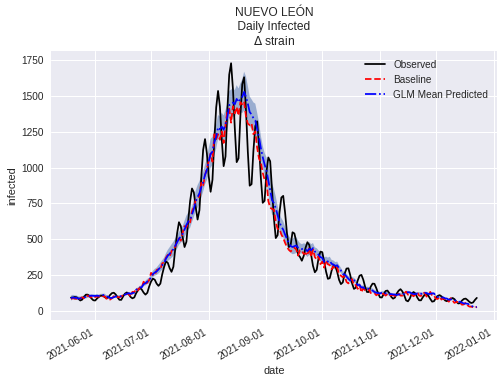

In [146]:
'''
Results for GLM model with Cox Baseline Process
'''
f=plt.figure()
plt.plot_date(date_state_delta[1:], cs_density_obs(
    days_delta[1:]), fmt='k-', label='Observed')
plt.plot_date(date_state_delta[1:], cs_density_baseline(days_delta[1:]), fmt='r--', label='Baseline')
plt.plot_date(date_state_delta[1:],cs_model_delta(days_delta[1:]),label='GLM Mean Predicted',fmt='b-.')
plt.fill_between(pd.to_datetime(pd.Series(date_state_delta[1:])),cs_conf_band_delta_mean_L(days_delta[1:]),cs_conf_band_delta_mean_U(days_delta[1:]),alpha=0.5)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_GLM_delta.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_GLM_delta.png')

# Gray PNG
img = Image.open(ImageDir+'density_GLM_delta.png').convert('LA')
img.save(ImageDir+'density_GLM_delta_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_GLM_delta.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_GLM_delta_gray.eps')
plt.show()

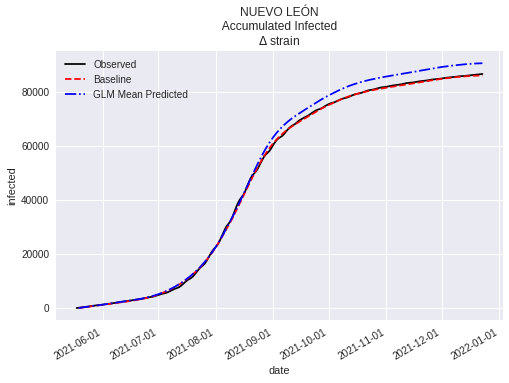

In [147]:
'''
Growth model throughout GLM model
'''
f=plt.figure()
#plt.fill_between(data_state_delta,A_acc_mean_delta_L,A_acc_mean_delta_U,delta=0.5)
plt.plot_date(date_state_delta, num_cum_delta, fmt='-k', label='Observed')
plt.plot_date(date_state_delta[1:], np.cumsum(cs_density_baseline(days_delta[1:])), fmt='r--', label='Baseline')
plt.plot_date(date_state_delta[1:],np.cumsum(cs_model_delta(days_delta[1:])),label='GLM Mean Predicted',fmt='b-.')
#plt.fill_between(pd.to_datetime(pd.Series(date_state_delta[1:])),np.cumsum(cs_conf_band_delta_mean_L(days_delta[1:])),np.cumsum(cs_conf_band_delta_mean_U(days_delta[1:])),alpha=0.3)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel('infected')
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_GLM_delta.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_GLM_delta.png',rasterized=True,dpi=300)
img = Image.open(ImageDir+'accumulated_GLM_delta.png').convert('LA')
img.save(ImageDir+'accumulated_GLM_delta_gray.png')
img = Image.open(ImageDir+'accumulated_GLM_delta.eps')
img.convert("L").save(ImageDir+'accumulated_GLM_delta_gray.eps')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_GLM_delta.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_GLM_delta.png')

# Gray PNG
img = Image.open(ImageDir+'accumulated_GLM_delta.png').convert('LA')
img.save(ImageDir+'accumulated_GLM_delta_gray.png')

# Gray EPS
img = Image.open(ImageDir+'accumulated_GLM_delta.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'accumulated_GLM_delta_gray.eps')
plt.show()

We compare these using Poisson Deviance metric

In [148]:
from sklearn.metrics import mean_poisson_deviance

deviance_error_baseline_delta=mean_poisson_deviance(G_sample_delta.num_dia_mean,X_baseline_delta)
deviance_error_GLM_delta=mean_poisson_deviance(G_sample_delta.num_dia_mean[1:],model_delta.mu)
deviance_error_acc_delta=mean_poisson_deviance(G_sample_delta.num_dia_mean,X_acc_mean_delta)
print('deviance delta baseline : %.4f' %(deviance_error_baseline_delta))
print('deviance delta proportional hazard: %.4f' %(deviance_error_GLM_delta))
print('deviance delta GLM: %.4f' %(deviance_error_acc_delta))

deviance delta baseline : 30.0347
deviance delta proportional hazard: 30.7929
deviance delta GLM: 32.3273


## $\Omicron$ process

Finally, we do the same with $\Omicron$ data

In [149]:
# omicron database
df_state_for_proof_omicron=df_state_for_proof[df_state_for_proof.Fecha>range_cepas_dates[2]]

# scale variables
'''
Accumulated data for omicron strain
'''
last_num_cum_delta=df_state_for_proof_delta.CasosAcumulados.to_list()[-1]
df_state_for_proof_omicron.CasosAcumulados=df_state_for_proof_omicron.CasosAcumulados.to_numpy()-last_num_cum_delta-last_num_cum_alpha

'''
Restart time
'''
df_state_for_proof_omicron.index=df_state_for_proof_omicron.index.to_numpy()-num_omicron_rt_begin
df_state_for_proof_omicron.head()

,Fecha,CasosAcumulados,CasosDiarios
1.0,2021-12-24,108.0,108.0
2.0,2021-12-25,150.0,42.0
3.0,2021-12-26,218.0,68.0
4.0,2021-12-27,545.0,327.0
5.0,2021-12-28,987.0,442.0


We get $R_t$ with new data.

In [150]:
''' 
Rt Omicron Updated
'''

x_axis_rt_omicron_1=convert_dates_to_days(omicron_rt_state_for_proof.date,range_dates_rt[0]).to_numpy()
rt_omicron_1=cs_rt_omicron(x_axis_rt_omicron_1)
df_aux=df_state_for_proof_omicron[df_state_for_proof_omicron['Fecha']>range_dates_rt[-1]]
x_axis_rt_omicron_2=convert_dates_to_days(df_aux.Fecha,range_dates_rt[0]).to_numpy()
rt_omicron_2=cs_rt_updated(x_axis_rt_omicron_2)
cs_rt_omicron_updated=inter_soft(np.concatenate([x_axis_rt_omicron_1,x_axis_rt_omicron_2]),
np.concatenate([rt_omicron_1,rt_omicron_2]),1)

'''
HDI 90% for Rt
'''
rt_omicron_1_L=cs_rt_omicron_L(x_axis_rt_omicron_1)
rt_omicron_2_L=cs_rt_updated_L(x_axis_rt_omicron_2)
cs_rt_omicron_L=inter_soft(np.concatenate([x_axis_rt_omicron_1,x_axis_rt_omicron_2]),
np.concatenate([rt_omicron_1_L,rt_omicron_2_L]),1)
rt_omicron_1_U=cs_rt_omicron_U(x_axis_rt_omicron_1)
rt_omicron_2_U=cs_rt_updated_U(x_axis_rt_omicron_2)
cs_rt_omicron_U=inter_soft(np.concatenate([x_axis_rt_omicron_1,x_axis_rt_omicron_2]),
np.concatenate([rt_omicron_1_U,rt_omicron_2_U]),1)


df_state_for_proof_omicron['Rt']=cs_rt_omicron_U(df_state_for_proof_omicron.index+num_omicron_rt_begin)
df_state_for_proof_omicron.head()

,Fecha,CasosAcumulados,CasosDiarios,Rt
1.0,2021-12-24,108.0,108.0,7.77
2.0,2021-12-25,150.0,42.0,6.60
3.0,2021-12-26,218.0,68.0,6.01
4.0,2021-12-27,545.0,327.0,4.90
5.0,2021-12-28,987.0,442.0,4.03


### Sampling

Get sample from `CasosAcumulados/CasosDiarios` data

In [151]:
import samples
importlib.reload(samples)
SAMPLES = 30
M_MEAN = 3
from samples import g_sample
SamplesDir = DataDir+'Samples/'
'''
Muestra cepa 
'''
G_sample_omicron=g_sample(df_state_for_proof_omicron,SamplesDir+state_for_proof+'_omicron.csv',SAMPLES,M_MEAN)
G_sample_omicron.main()
df_sample_omicron=G_sample_omicron.get_sampling_data()
df_sample_omicron['Rt']=cs_rt_omicron_U(df_sample_omicron.tiempo.to_numpy()+num_omicron_rt_begin)

We check the last sampling

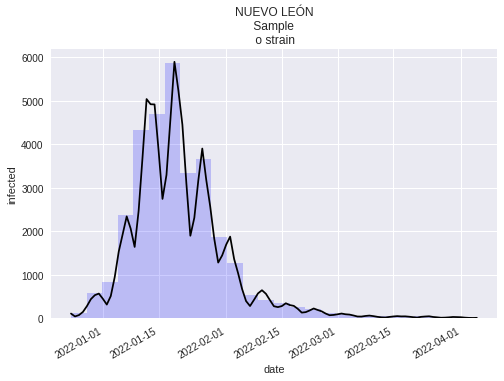

In [152]:
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.dates import DateFormatter
from datetime import timedelta

# Date format
date_format = DateFormatter('%Y-%m-%d')

# Sample in date
sample_date_omicron=[]
sample_num_omicron=df_sample_omicron.tiempo.to_numpy()
for i in range(len(sample_num_omicron)):
    sample_date_omicron.append(range_cepas_dates[2]+timedelta(days=int(sample_num_omicron[i])))

# Date for truncation
umbral_date=dt.datetime(2022,2,1)

# Visualization
plt.style.use('seaborn')
f=plt.figure()
plt.plot_date(df_state_for_proof_omicron.Fecha,G_sample_omicron.num_dia_mean,fmt='k-')
plt.hist(sample_date_omicron,
         orientation='vertical', alpha=0.2, bins=26, color='b')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n Sample \n o strain')
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.savefig(ImageDir+'sample_omicron.png')
f.savefig(ImageDir+'sample_omicron.pdf')
f.set_rasterized(True)
f.savefig(ImageDir+'sample_omicron.eps',rasterized=True,dpi=300)


# Gray PNG
img = Image.open(ImageDir+'sample_omicron.png').convert('LA')
img.save(ImageDir+'sample_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'sample_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'sample_omicron_gray.eps')
plt.show()

Now we plot $R_t$

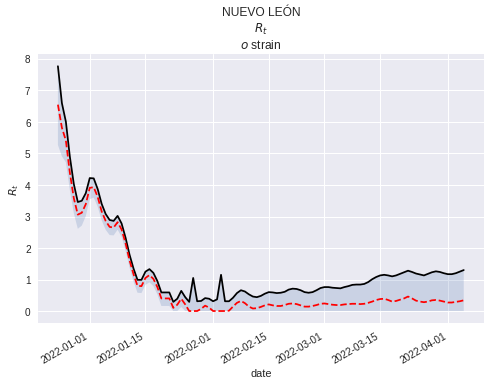

In [153]:
f=plt.figure()
plt.plot_date(df_state_for_proof_omicron.Fecha,df_state_for_proof_omicron.Rt,fmt='k-')
plt.plot_date(df_state_for_proof_omicron.Fecha,cs_rt_omicron_updated(df_state_for_proof_omicron.index+num_omicron_rt_begin),fmt='r--')
plt.fill_between(df_state_for_proof_omicron.Fecha,cs_rt_omicron_L(df_state_for_proof_omicron.index+num_omicron_rt_begin),cs_rt_omicron_U(df_state_for_proof_omicron.index+num_omicron_rt_begin),alpha=0.2)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n'+r'$R_t$'+'\n'+r'$o$ strain')
plt.xlabel('date')
plt.ylabel(r'$R_t$')
f.set_rasterized(True)
f.savefig(ImageDir+'rt_omicron.eps',rasterized=True,dpi=300)
plt.show()

How we use this strain as example of truncated data we show the plot with a vertical line representing the truncation that we are going to treat later.

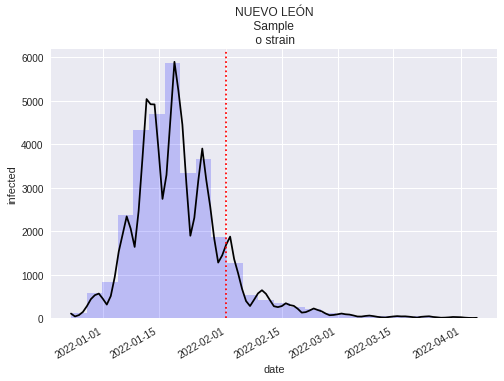

In [154]:
# Visualization
plt.style.use('seaborn')
f=plt.figure()
plt.plot_date(df_state_for_proof_omicron.Fecha,G_sample_omicron.num_dia_mean,fmt='k-')
plt.hist(sample_date_omicron,
         orientation='vertical', alpha=0.2, bins=26, color='b')
plt.axvline(umbral_date,linestyle='dotted',color='r')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n Sample \n o strain')
plt.xlabel('date')
plt.ylabel('infected')
f.set_rasterized(True)
f.savefig(ImageDir+'sample_omicron_with_trun.eps',rasterized=True,dpi=300)
plt.show()

We convert `umbral_date` into numerical value

In [155]:
num_umbral_date = np.squeeze(convert_dates_to_days(
    pd.Series(umbral_date), range_dates_rt[0]))

### Initial conditions

We are going to get Gompertz-Mixture parameters for $\Omicron$ strain. Firts, we determine initial conditions

In [156]:
import initial_conditions
importlib.reload(initial_conditions)
from initial_conditions import estimate_initial_parameters_risk
G = [1, 2, 3, 4]
'''
Initial conditions regression version 1
'''
np.random.seed(1)
data_state_omicron = df_state_for_proof_omicron.copy()
data_sample_omicron = df_sample_omicron.copy()
baseline_IC_state_for_proof_omicron= estimate_initial_parameters_risk(
    G, data_sample_omicron, data_state_omicron)
baseline_IC_state_for_proof_omicron

{0: array([-7.36524616, -0.29899023]),
 1: array([-4.51470498, -0.0849115 ]),
 2: array([-2.71325305, -0.00473338]),
 'prob_a_priori': array([0.1022735, 0.4671208, 0.4306057])}

### Estimation

We run EM Algorithm in order to get Gompertz-Mixture parameters for this process

In [157]:
import opt_baseline
importlib.reload(opt_baseline)
from opt_baseline import mgomp

'''
Preparing Initial Conditions
'''
G = len(baseline_IC_state_for_proof_omicron['prob_a_priori'])
num_parameters = 2
est_in = np.empty((G, num_parameters))
pi_in = baseline_IC_state_for_proof_omicron['prob_a_priori']

for i in range(G):
    est_in[i] = baseline_IC_state_for_proof_omicron[i]
    est_in[i][1] =est_in[i][1]

'''
Esimation and Results
'''
NBOOT = 1
MG_baseline_omicron = mgomp(df_sample_omicron, NBOOT, est_in, pi_in,G)
MG_baseline_omicron.getest()
MG_baseline_omicron.output()

Initial parameters: 
[[-7.36524616e+00 -2.98990232e-01]
 [-4.51470498e+00 -8.49114971e-02]
 [-2.71325305e+00 -4.73337861e-03]]

Results summarize
Bootstrap= 0, Iter= 72


Component 0: gamma= -11.3871, kappa= -0.5246
Component 1: gamma= -5.9603, kappa= -0.1290
Component 2: gamma= -4.9344, kappa= -0.0381


Mixture proportion 0: 0.1371
Mixture proportion 1: 0.6972
Mixture proportion 2: 0.1657


In [158]:
'''
Baseline Hazard and Cum Hazard version 1
'''
data_sample = df_sample_omicron.copy()
data_state = df_state_for_proof_omicron.copy()

days_omicron = data_state_omicron.index.to_numpy()
cum_hazard_omicron, hazard_omicron= MG_baseline_omicron.hazard(days_omicron)

'''
Rt coefficients
'''
importlib.reload(initial_conditions)
from initial_conditions import estimate_parameters_Rt_cum_hazard,estimate_parameters_Rt_hazard

'''
Estimation of Rt coeficients
'''
cs_cum_hazard_par_omicron = inter_soft(days_omicron, cum_hazard_omicron, 1)
cs_hazard_par_omicron=inter_soft(days_omicron,hazard_omicron,1)
Rt_coef_hazard_omicron, labels_cum_hazard_omicron, gm_cum_hazard_omicron = estimate_parameters_Rt_hazard(
    [1], data_sample, data_state, cs_hazard_par_omicron
)
print('Rt coefficients for accelerated risk: ')
print(Rt_coef_hazard_omicron)

Rt coefficients for accelerated risk: 
[-0.02893765]


### Asymptotes

#### Baseline $\Omicron$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  1894617552.1849642
zk =  [45.0062648]
f(zk) =  12105821.656350613
|pk| =  2.105964500509761e-10
k =  7


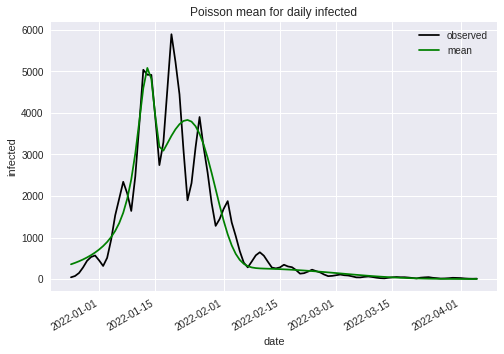

In [159]:
importlib.reload(initial_conditions)
from initial_conditions import *

# Get initial number of susceptibles
num_cum_omicron = G_sample_omicron.num_cum_mean
a_omicron=cum_hazard_omicron[1:]-cum_hazard_omicron[:-1]
a_omicron=np.concatenate(([0.0],a_omicron))
b_omicron=np.array([np.prod(1.0-a_omicron[:i+1]) for i in range(len(a_omicron))])
#b_omicron=np.concatenate(([1.0],b_omicron))

# Data for optimization
x_omicron=b_omicron[1:]-b_omicron[:-1]
y_omicron=num_cum_omicron[1:]-num_cum_omicron[:-1]
date_omicron=df_state_for_proof_omicron.Fecha.to_list()[1:]
Y0_omicron=num_cum_omicron[0]
P_omicron=pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_omicron=np.array([x_omicron,y_omicron]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_omicron,model_mean_baseline_omicron=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_omicron,P_omicron,Y0_omicron,date_omicron)

# Color EPS and PNG
f.savefig(ImageDir+'LM_omicron.png')
f.savefig(ImageDir+'LM_omicron.pdf')
f.set_rasterized(True)
f.savefig(ImageDir+'LM_omicron.eps',rasterized=True,dpi=300)


# Gray PNG
img = Image.open(ImageDir+'LM_omicron.png').convert('LA')
img.save(ImageDir+'LM_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_omicron_gray.eps')
plt.show()

#### Proportional Hazard $\Omicron$

Levenberg-Marquardt algorithm CONVERGED
z0 =  2.0
f(z0) =  17334380171.591644
zk =  [23.22952333]
f(zk) =  11989199.776910145
|pk| =  7.467795920207115e-09
k =  8


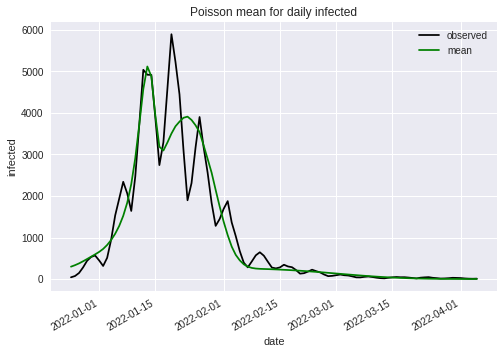

In [160]:
# Corresponding Rt
rt_acc_omicron = df_state_for_proof_omicron.Rt.to_numpy()
rt_acc_omicron = rt_acc_omicron-np.mean(rt_acc_omicron)

# Accelerated cumulative risk
cum_hazard_omicron_acc, hazard_omicron_acc=MG_baseline_omicron.hazard_acc(days_omicron,rt_acc_omicron,Rt_coef_hazard_omicron[0])
a_omicron_acc=cum_hazard_omicron_acc[1:]-cum_hazard_omicron_acc[:-1]
a_omicron_acc=np.concatenate(([0.0],a_omicron_acc))
b_omicron_acc=np.array([np.prod(1.0-a_omicron_acc[:i+1]) for i in range(len(a_omicron_acc))])
#b_omicron_acc=np.concatenate(([1.0],b_omicron_acc))

# Data for optimization
x_omicron_acc=b_omicron_acc[1:]-b_omicron_acc[:-1]
y_omicron_acc=num_cum_omicron[1:]-num_cum_omicron[:-1]
date_omicron=df_state_for_proof_omicron.Fecha.to_list()[1:]
Y0_omicron=num_cum_omicron[0]
P_omicron=pob*0.51
k0=2.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_omicron=np.array([x_omicron_acc,y_omicron_acc]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_omicron_acc, model_acc_mean_omicron=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_omicron,P_omicron,Y0_omicron,date_omicron)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_omicron_acc.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_omicron_acc.png')

# Gray PNG
img = Image.open(ImageDir+'LM_omicron_acc.png').convert('LA')
img.save(ImageDir+'LM_omicron_acc_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_omicron_acc.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_omicron_acc_gray.eps')
plt.show()

#### Accelerated Between $\Omicron$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  591947904.6543106
zk =  [35.52143538]
f(zk) =  88335220.82398741
|pk| =  2.437111571455165e-12
k =  7


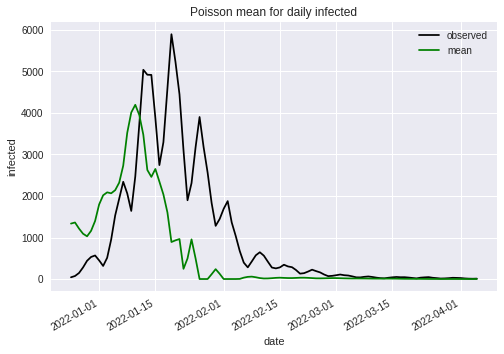

In [161]:
# Get initial number of susceptibles
num_cum_omicron = G_sample_omicron.num_cum_mean
a_omicron=cum_hazard_omicron[1:]-cum_hazard_omicron[:-1]
a_omicron=np.concatenate(([0.0],a_omicron))
b_omicron=np.array([np.prod(1.0-a_omicron[:i+1]) for i in range(len(a_omicron))])
#b_omicron=np.concatenate(([1.0],b_omicron))

# Data for optimization
x_omicron=cs_rt_omicron_updated(days_omicron[1:]+num_omicron_rt_begin)*(b_omicron[1:]-b_omicron[:-1])
y_omicron=num_cum_omicron[1:]-num_cum_omicron[:-1]
date_omicron=df_state_for_proof_omicron.Fecha.to_list()[1:]
Y0_omicron=num_cum_omicron[0]
P_omicron=pob*0.51
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_omicron=np.array([x_omicron,y_omicron]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_omicron_B,model_acc_mean_omicron_B=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_omicron,P_omicron,Y0_omicron,date_omicron)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_omicron_B.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_omicron_B.png')

# Gray PNG
img = Image.open(ImageDir+'LM_omicron_B.png').convert('LA')
img.save(ImageDir+'LM_omicron_B_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_omicron_B.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_omicron_B_gray.eps')
plt.show()

#### Accelerated Lower $\Omicron$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  458554486.76002014
zk =  [34.19919293]
f(zk) =  105262276.60550399
|pk| =  1.5472557948944862e-12
k =  7


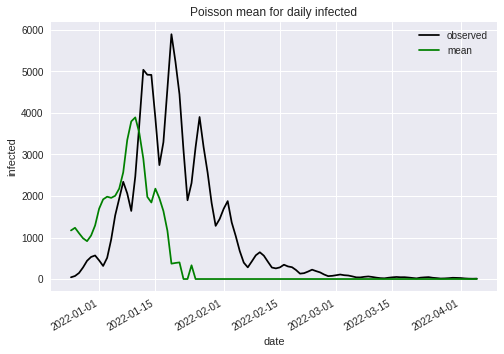

In [162]:
# Get initial number of susceptibles
num_cum_omicron = G_sample_omicron.num_cum_mean
a_omicron=cum_hazard_omicron[1:]-cum_hazard_omicron[:-1]
a_omicron=np.concatenate(([0.0],a_omicron))
b_omicron=np.array([np.prod(1.0-a_omicron[:i+1]) for i in range(len(a_omicron))])

# Data for optimization
x_omicron=cs_rt_omicron_L(days_omicron[1:]+num_omicron_rt_begin)*(b_omicron[1:]-b_omicron[:-1])
y_omicron=num_cum_omicron[1:]-num_cum_omicron[:-1]
date_omicron=df_state_for_proof_omicron.Fecha.to_list()[1:]
Y0_omicron=num_cum_omicron[0]
P_omicron=pob*0.51
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_omicron=np.array([x_omicron,y_omicron]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_omicron_L,model_acc_mean_omicron_L=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_omicron,P_omicron,Y0_omicron,date_omicron)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_omicron_L.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_omicron_L.png')

# Gray PNG
img = Image.open(ImageDir+'LM_omicron_L.png').convert('LA')
img.save(ImageDir+'LM_omicron_L_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_omicron_L.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_omicron_L_gray.eps')
plt.show()

#### Accelerated Upper $\Omicron$

Levenberg-Marquardt algorithm CONVERGED
z0 =  10.0
f(z0) =  3767389949.841752
zk =  [71.0921745]
f(zk) =  66573758.79381077
|pk| =  3.2201072636747274e-10
k =  8


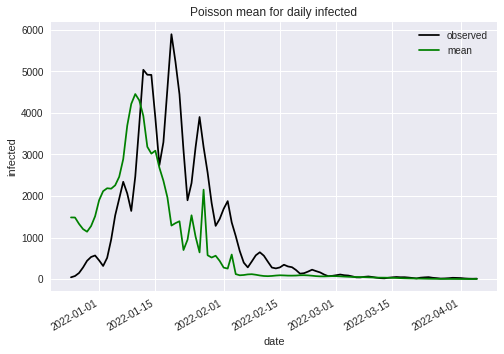

In [163]:
# Get initial number of susceptibles
num_cum_omicron = G_sample_omicron.num_cum_mean
a_omicron=cum_hazard_omicron[1:]-cum_hazard_omicron[:-1]
a_omicron=np.concatenate(([0.0],a_omicron))
b_omicron=np.array([np.prod(1.0-a_omicron[:i+1]) for i in range(len(a_omicron))])

# Data for optimization
x_omicron=cs_rt_omicron_U(days_omicron[1:]+num_omicron_rt_begin)*(b_omicron[1:]-b_omicron[:-1])
y_omicron=num_cum_omicron[1:]-num_cum_omicron[:-1]
date_omicron=df_state_for_proof_omicron.Fecha.to_list()[1:]
Y0_omicron=num_cum_omicron[0]
P_omicron=pob
k0=10.0

# Optimization
N=5000
tol=np.finfo(float).eps**(1/2)
paramf_omicron=np.array([x_omicron,y_omicron]).T
mu_ref=0.1
f=plt.figure()
dic_results_asym_omicron_U,model_acc_mean_omicron_U=proof_levenberg_marquardt_nlls(R,J,k0,N,tol,mu_ref,paramf_omicron,P_omicron,Y0_omicron,date_omicron)

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'LM_omicron_U.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'LM_omicron_U.png')

# Gray PNG
img = Image.open(ImageDir+'LM_omicron_U.png').convert('LA')
img.save(ImageDir+'LM_omicron_U_gray.png')

# Gray EPS
img = Image.open(ImageDir+'LM_omicron_U.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'LM_omicron_U_gray.eps')
plt.show()

### Analytic Solution

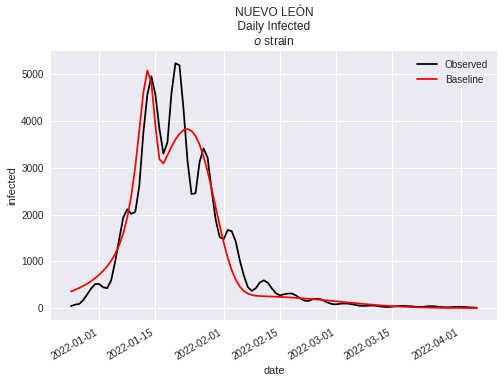

In [164]:
'''
Density omicron process
'''
from opt_baseline import mobile_mean

date_state_omicron = df_state_for_proof_omicron.Fecha.to_list()

'''
Interpolation
'''
SOFT_PAR = 1
cs_density_baseline = inter_soft(
    days_omicron[1:], model_mean_baseline_omicron, SOFT_PAR)
cs_density_acc = inter_soft(
    days_omicron[1:], model_acc_mean_omicron, SOFT_PAR)
cs_density_acc_B = inter_soft(
    days_omicron[1:], model_acc_mean_omicron_B, SOFT_PAR)
cs_density_acc_L = inter_soft(
    days_omicron[1:], model_acc_mean_omicron_L, SOFT_PAR)
cs_density_acc_U = inter_soft(
    days_omicron[1:], model_acc_mean_omicron_U, SOFT_PAR)
cs_density_obs = mobile_mean(
    days_omicron[1:], num_cum_omicron[1:]-num_cum_omicron[:-1], M_MEAN)

'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_state_omicron[1:], cs_density_obs(
    days_omicron[1:]), fmt='k-', label='Observed')
plt.plot_date(date_state_omicron[1:], cs_density_baseline(days_omicron[1:]), fmt='r-', label='Baseline')
#plt.plot_date(date_state_omicron[1:], cs_density_acc(days_omicron[1:]), fmt='b--', label='Accelerated')
#plt.plot_date(date_state_omicron[1:], cs_density_acc_B(days_omicron[1:]), fmt='-.g', label='Between')
#plt.plot_date(date_state_omicron[1:], cs_density_acc_L(days_omicron[1:]), fmt='-.g', label='Lower')
#plt.plot_date(date_state_omicron[1:], cs_density_acc_U(days_omicron[1:]), fmt='-.g', label='Upper')
#plt.fill_between(pd.to_datetime(pd.Series(date_state_omicron[1:])),cs_density_acc_L(days_omicron[1:]),cs_density_acc_U(days_omicron[1:]),omicron=0.2)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$o$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.savefig(ImageDir+'density_omicron.png')
f.savefig(ImageDir+'density_omicron.pdf')
f.set_rasterized(True)
f.savefig(ImageDir+'density_omicron.eps',rasterized=True,dpi=300)


# Gray PNG
img = Image.open(ImageDir+'density_omicron.png').convert('LA')
img.save(ImageDir+'density_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_omicron_gray.eps')
plt.show()

### Simulation

#### Baseline

In [165]:
from scipy.stats import poisson
'''
Poisson process baseline model
'''
k_omicron=np.squeeze(dic_results_asym_omicron['zk'])
# Poisson process
X_baseline_omicron = np.empty(len(days_omicron))
A_baseline_omicron = np.empty(len(days_omicron))
X_baseline_omicron[0] = num_cum_omicron[0]
A_baseline_omicron[0] = X_baseline_omicron[0]
for i in range(1, len(X_baseline_omicron)):
    if i <= len(num_cum_omicron)-1:
        mu_est = (P_omicron/k_omicron-A_baseline_omicron[i-1]) * \
            (cum_hazard_omicron[i]-cum_hazard_omicron[i-1])
    else:
        mu_est = (num_cum_omicron[0])*(cum_hazard_omicron[i]-cum_hazard_omicron[i-1])
    X_baseline_omicron[i] = poisson.rvs(mu=mu_est)
    A_baseline_omicron[i] = A_baseline_omicron[i-1]+X_baseline_omicron[i]

#### Proportional Hazard

In [166]:
'''
Poisson process other accelerated model
'''
rt_omicron_updated = cs_rt_omicron_updated(days_omicron+num_omicron_rt_begin)
k_omicron=np.squeeze(dic_results_asym_omicron['zk'])

# Poisson process
X_acc_mean_omicron = np.empty(len(days_omicron))
A_acc_mean_omicron = np.empty(len(days_omicron))
X_acc_mean_omicron[0] = num_cum_omicron[0]
A_acc_mean_omicron[0] = X_acc_mean_omicron[0]
for i in range(1, len(X_acc_mean_omicron)):
    if i <= len(num_cum_omicron)-1:
        mu_est = np.exp(rt_omicron_updated[i-1]/12)*(P_omicron/k_omicron-A_acc_mean_omicron[i-1]) * \
            (cum_hazard_omicron[i]-cum_hazard_omicron[i-1])
    else:
        mu_est = (num_cum_omicron[0])*(cum_hazard_omicron[i]-cum_hazard_omicron[i-1])
    X_acc_mean_omicron[i] = poisson.rvs(mu=mu_est)
    A_acc_mean_omicron[i] = A_acc_mean_omicron[i-1]+X_acc_mean_omicron[i]

### Simulation Results

We obtain the growth model 

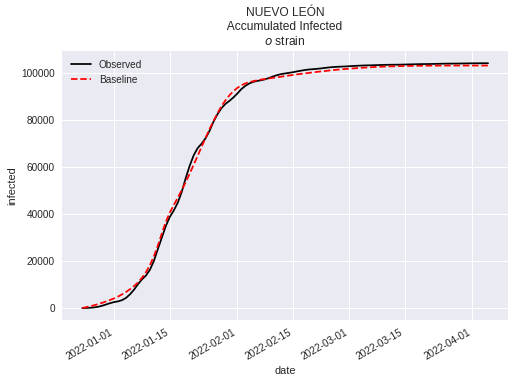

In [167]:
'''
Growth model omicron process
'''

date_state_omicron = df_state_for_proof_omicron.Fecha.to_list()

f=plt.figure()
plt.plot_date(date_state_omicron, num_cum_omicron, fmt='-k', label='Observed')
plt.plot_date(date_state_omicron, A_baseline_omicron, fmt='--r',label='Baseline')
#plt.plot_date(date_state_omicron, A_acc_mean_omicron, fmt=':b', label='Accelerated')


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$o$ strain')
plt.xlabel('date')
plt.ylabel('infected')

f.savefig(ImageDir+'accumulated_omicron.png')
f.savefig(ImageDir+'accumulated_omicron.pdf')
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_omicron.eps',rasterized=True,dpi=300)


img = Image.open(ImageDir+'accumulated_omicron.png').convert('LA')
img.save(ImageDir+'accumulated_omicron_gray.png')
img = Image.open(ImageDir+'accumulated_omicron.eps')
img.convert("L").save(ImageDir+'accumulated_omicron_gray.eps')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_omicron.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_omicron.png')

# Gray PNG
img = Image.open(ImageDir+'accumulated_omicron.png').convert('LA')
img.save(ImageDir+'accumulated_omicron_gray.png')

The density is

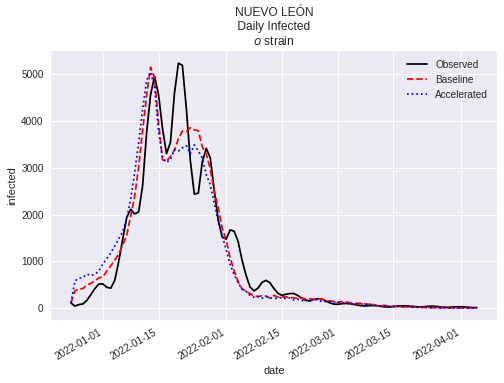

In [168]:
'''
Density omicron process
'''
from opt_baseline import mobile_mean
'''
Interpolation
'''
SOFT_PAR = 1
cs_density_baseline = inter_soft(
    days_omicron, X_baseline_omicron, SOFT_PAR)
cs_density_acc = inter_soft(
    days_omicron, X_acc_mean_omicron, SOFT_PAR)
cs_density_obs = mobile_mean(
    days_omicron,np.concatenate([[num_cum_omicron[0]],num_cum_omicron[1:]-num_cum_omicron[:-1]]), M_MEAN)

'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_state_omicron, cs_density_obs(
    days_omicron), fmt='k-', label='Observed')
plt.plot_date(date_state_omicron, cs_density_baseline(
    days_omicron), fmt='r--', label='Baseline')
plt.plot_date(date_state_omicron, cs_density_acc(days_omicron), fmt='b:', label='Accelerated')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$o$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_omicron.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_omicron.png')

# Gray PNG
img = Image.open(ImageDir+'density_omicron.png').convert('LA')
img.save(ImageDir+'density_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_omicron_gray.eps')
plt.show()

### Negative Binomial Regression

In [169]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = "Y ~ log_Rt+0"
rt_omicron_GLM=cs_rt_omicron_U(days_omicron+num_omicron_rt_begin)+0.1
log_model_mean_omicron_GLM=np.log(cs_density_baseline(days_omicron)+1)

data_Reg_omicron=pd.DataFrame({'Y': np.concatenate([[num_cum_omicron[0]],num_cum_omicron[1:]-num_cum_omicron[:-1]]),'log_baseline_mean':log_model_mean_omicron_GLM,'log_Rt':np.log(rt_omicron_GLM)})
model_omicron = smf.glm(formula=formula, data=data_Reg_omicron,offset=log_model_mean_omicron_GLM,family=sm.families.NegativeBinomial()).fit()
print(model_omicron.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                  103
Model:                            GLM   Df Residuals:                      102
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -742.93
Date:                Sat, 10 Dec 2022   Deviance:                       142.34
Time:                        19:46:35   Pearson chi2:                     771.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_Rt         0.2218      0.142      1.567      0.1

### Visualization

Obtain confidence intervals

In [170]:
from scipy.stats import norm
''' 
Necessary elements 
'''
X_omicron=np.column_stack([np.log(rt_omicron_GLM)])
var_coeff=model_omicron.cov_params()
'''
Variance Linear Predictor
'''
var_lin_pred_omicron=np.array([np.squeeze(X_omicron[i,:].reshape(1,-1)@var_coeff@X_omicron[i,:].reshape(1,-1).T) for i in range(X_omicron.shape[0])])
se_lin_pred_omicron=np.sqrt(var_lin_pred_omicron)
beta_omicron=np.asarray(model_omicron.params).reshape(-1,1)
lin_pred_omicron=np.squeeze(X_omicron@beta_omicron)+log_model_mean_omicron_GLM
''' 
Wald Interval Linear Predictor
'''
level_band=0.01
z_a=norm.ppf(1-level_band/2)
conf_band_omicron_lin_pred_L=lin_pred_omicron-z_a*se_lin_pred_omicron
conf_band_omicron_lin_pred_U=lin_pred_omicron+z_a*se_lin_pred_omicron

'''
Wald Interval for mean
'''
M_MEAN_CI=3

cs_model_omicron=mobile_mean(days_omicron,model_omicron.mu,M_MEAN_CI)
conf_band_omicron_mean_L=np.exp(conf_band_omicron_lin_pred_L)
cs_conf_band_omicron_mean_L=mobile_mean(days_omicron,conf_band_omicron_mean_L,M_MEAN_CI)
conf_band_omicron_mean_U=np.exp(conf_band_omicron_lin_pred_U)
cs_conf_band_omicron_mean_U=mobile_mean(days_omicron,conf_band_omicron_mean_U,M_MEAN_CI)

Here we have the density and growth curve

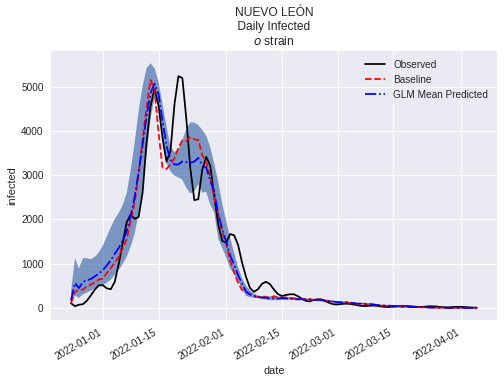

In [171]:
'''
Results for GLM model with Cox Baseline Process
'''
f=plt.figure()
plt.plot_date(date_state_omicron, cs_density_obs(
    days_omicron), fmt='k-', label='Observed')
plt.plot_date(date_state_omicron, cs_density_baseline(days_omicron), fmt='r--', label='Baseline')
plt.plot_date(date_state_omicron,cs_model_omicron(days_omicron),label='GLM Mean Predicted',fmt='b-.')
plt.fill_between(pd.to_datetime(pd.Series(date_state_omicron)),cs_conf_band_omicron_mean_L(days_omicron),cs_conf_band_omicron_mean_U(days_omicron),alpha=0.7)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$o$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'density_GLM_omicron.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'density_GLM_omicron.png')

# Gray PNG
img = Image.open(ImageDir+'density_GLM_omicron.png').convert('LA')
img.save(ImageDir+'density_GLM_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_GLM_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_GLM_omicron_gray.eps')
plt.show()

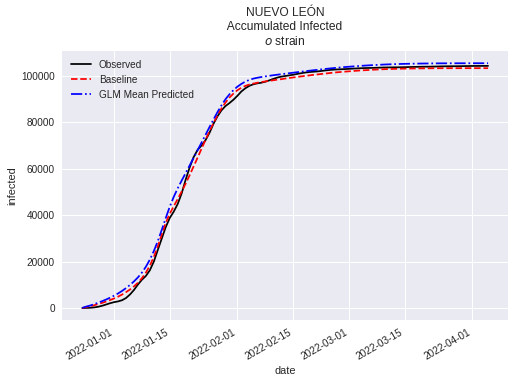

In [172]:
'''
Growth model throughout GLM model
'''
f=plt.figure()
#plt.fill_between(data_state_omicron,A_acc_mean_omicron_L,A_acc_mean_omicron_U,omicron=0.5)
plt.plot_date(date_state_omicron, num_cum_omicron, fmt='-k', label='Observed')
plt.plot_date(date_state_omicron, np.cumsum(cs_density_baseline(days_omicron)), fmt='r--', label='Baseline')
plt.plot_date(date_state_omicron,np.cumsum(cs_model_omicron(days_omicron)),label='GLM Mean Predicted',fmt='b-.')
#plt.fill_between(pd.to_datetime(pd.Series(date_state_omicron)),np.cumsum(cs_conf_band_omicron_mean_L(days_omicron)),np.cumsum(cs_conf_band_omicron_mean_U(days_omicron)),alpha=0.3)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$o$ strain')
plt.xlabel('date')
plt.ylabel('infected')
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_GLM_omicron.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_GLM_omicron.png',rasterized=True,dpi=300)
img = Image.open(ImageDir+'accumulated_GLM_omicron.png').convert('LA')
img.save(ImageDir+'accumulated_GLM_omicron_gray.png')
img = Image.open(ImageDir+'accumulated_GLM_omicron.eps')
img.convert("L").save(ImageDir+'accumulated_GLM_omicron_gray.eps')

# Color EPS and PNG
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_GLM_omicron.eps',rasterized=True,dpi=300)
f.savefig(ImageDir+'accumulated_GLM_omicron.png')

# Gray PNG
img = Image.open(ImageDir+'accumulated_GLM_omicron.png').convert('LA')
img.save(ImageDir+'accumulated_GLM_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'accumulated_GLM_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'accumulated_GLM_omicron_gray.eps')
plt.show()

We compare these models with Poisson Deviance

In [173]:
from sklearn.metrics import mean_poisson_deviance

idx_positive_baseline_omicron=np.where(X_baseline_omicron>0)
idx_positive_acc_mean_omicron=np.where(X_acc_mean_omicron>0)

deviance_error_baseline_omicron=mean_poisson_deviance(G_sample_omicron.num_dia_mean[idx_positive_baseline_omicron],X_baseline_omicron[idx_positive_baseline_omicron])
deviance_error_GLM_omicron=mean_poisson_deviance(G_sample_omicron.num_dia_mean,model_omicron.mu)
deviance_error_acc_omicron=mean_poisson_deviance(G_sample_omicron.num_dia_mean[idx_positive_acc_mean_omicron],X_acc_mean_omicron[idx_positive_acc_mean_omicron])
print('deviance omicron baseline : %.4f' %(deviance_error_baseline_omicron))
print('deviance omicron proportional hazard: %.4f' %(deviance_error_GLM_omicron))
print('deviance omicron GLM: %.4f' %(deviance_error_acc_omicron))

deviance omicron baseline : 126.9886
deviance omicron proportional hazard: 158.9572
deviance omicron GLM: 154.7133


## Total process

We concatenate the last process and obtain the total dynamic in COVID-19 timeline

In [174]:
date_total=df_state_for_proof.Fecha.to_list()
days_total=df_state_for_proof.index.to_numpy()
cs_num_cum_total=mobile_mean(days_total,df_state_for_proof.CasosAcumulados.to_numpy(),M_MEAN)
cs_num_dia_total=mobile_mean(days_total,df_state_for_proof.CasosDiarios.to_numpy(),M_MEAN)


''' 
Prediction per strain
'''
density_model_alpha_mu=np.concatenate(([num_cum_alpha[0]],model_alpha.mu))
density_model_delta_mu=np.concatenate(([num_cum_delta[0]],model_delta.mu))
density_model_omicron_mu=model_omicron.mu

cum_model_alpha_mu=np.cumsum(density_model_alpha_mu)
cum_model_delta_mu=np.cumsum(density_model_delta_mu)
cum_model_omicron_mu=np.cumsum(density_model_omicron_mu)


''' 
Confidence bands
'''
density_model_alpha_mu_L=np.concatenate(([num_cum_alpha[0]],conf_band_alpha_mean_L))
density_model_delta_mu_L=np.concatenate(([num_cum_delta[0]],conf_band_delta_mean_L))
density_model_omicron_mu_L=conf_band_omicron_mean_L

cum_model_alpha_mu_L=np.cumsum(density_model_alpha_mu_L)
cum_model_delta_mu_L=np.cumsum(density_model_delta_mu_L)
cum_model_omicron_mu_L=np.cumsum(density_model_omicron_mu_L)

density_model_alpha_mu_U=np.concatenate(([num_cum_alpha[0]],conf_band_alpha_mean_U))
density_model_delta_mu_U=np.concatenate(([num_cum_delta[0]],conf_band_delta_mean_U))
density_model_omicron_mu_U=conf_band_omicron_mean_U

cum_model_alpha_mu_U=np.cumsum(density_model_alpha_mu_U)
cum_model_delta_mu_U=np.cumsum(density_model_delta_mu_U)
cum_model_omicron_mu_U=np.cumsum(density_model_omicron_mu_U)


''' 
Total process
'''

# Density
X_baseline_total=np.concatenate((X_baseline_alpha,X_baseline_delta,X_baseline_omicron))
X_acc_model=np.concatenate((density_model_alpha_mu,density_model_delta_mu,density_model_omicron_mu))
X_acc_model_L=np.concatenate((density_model_alpha_mu_L,density_model_delta_mu_L,density_model_omicron_mu_L))
X_acc_model_U=np.concatenate((density_model_alpha_mu_U,density_model_delta_mu_U,density_model_omicron_mu_U))

# Growth model
A_baseline_total=np.concatenate((A_baseline_alpha,A_baseline_delta+A_baseline_alpha[-1],A_baseline_omicron+A_baseline_alpha[-1]+A_baseline_delta[-1]))

A_acc_model=np.concatenate((cum_model_alpha_mu,cum_model_delta_mu+cum_model_alpha_mu[-1],cum_model_omicron_mu+cum_model_alpha_mu[-1]+cum_model_delta_mu[-1]))
A_acc_model_L=np.concatenate((cum_model_alpha_mu_L,cum_model_delta_mu_L+cum_model_alpha_mu_L[-1],cum_model_omicron_mu_L+cum_model_alpha_mu_L[-1]+cum_model_delta_mu_L[-1]))
A_acc_model_U=np.concatenate((cum_model_alpha_mu_U,cum_model_delta_mu_U+cum_model_alpha_mu_U[-1],cum_model_omicron_mu_U+cum_model_alpha_mu_U[-1]+cum_model_delta_mu_U[-1]))

We show the total growth curve

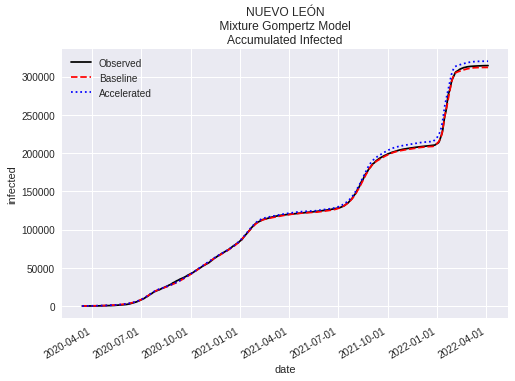

In [175]:
'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_total,cs_num_cum_total(days_total), fmt='k-', label='Observed')
plt.plot_date(date_total,A_baseline_total, fmt='r--', label='Baseline')
plt.plot_date(date_total,A_acc_model, fmt='b:', label='Accelerated')
#plt.fill_between(date_total,A_acc_model_L,A_acc_model_U,alpha=0.3)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Mixture Gompertz Model \nAccumulated Infected')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.savefig(ImageDir+'accumulated_total.png')
f.savefig(ImageDir+'accumulated_total.pdf')
f.set_rasterized(True)
f.savefig(ImageDir+'accumulated_total.eps',rasterized=True,dpi=300)


# Gray PNG
img = Image.open(ImageDir+'accumulated_total.png').convert('LA')
img.save(ImageDir+'accumulated_total_gray.png')

# Gray EPS
img = Image.open(ImageDir+'accumulated_total.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'accumulated_total_gray.eps')
plt.show()

And the density is

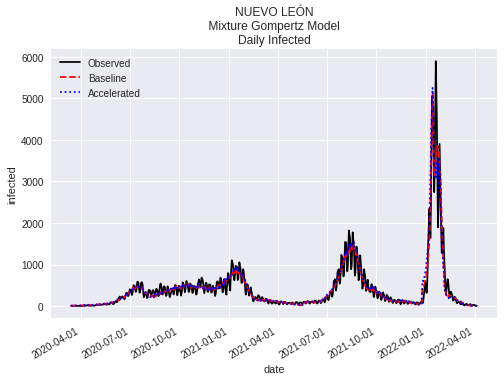

In [176]:
'''
Plotting
'''
f=plt.figure()
plt.plot_date(date_total,cs_num_dia_total(days_total), fmt='k-', label='Observed')
plt.plot_date(date_total,X_baseline_total, fmt='r--', label='Baseline')
plt.plot_date(date_total,X_acc_model, fmt='b:', label='Accelerated')
#plt.fill_between(date_total,X_acc_model_L,X_acc_model_U,alpha=0.7)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Mixture Gompertz Model \nDaily Infected')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.savefig(ImageDir+'density_total.png')
f.savefig(ImageDir+'density_total.pdf')
f.set_rasterized(True)
f.savefig(ImageDir+'density_total.eps',rasterized=True,dpi=300)

# Gray PNG
img = Image.open(ImageDir+'density_total.png').convert('LA')
img.save(ImageDir+'density_total_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_total.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_total_gray.eps')
plt.show()

Finally, we get deviance for each model

In [177]:
from sklearn.metrics import mean_poisson_deviance

idx_pos_baseline_total=np.where(X_baseline_total>0)
idx_pos_acc_cum_hazard_total=np.where(X_acc_model>0)

deviance_error_baseline_total=mean_poisson_deviance(cs_num_dia_total(days_total)[idx_pos_baseline_total],X_baseline_total[idx_pos_baseline_total])
deviance_error_acc_cum_hazard_total=mean_poisson_deviance(cs_num_dia_total(days_total)[idx_pos_acc_cum_hazard_total],X_acc_model[idx_pos_acc_cum_hazard_total])
print('deviance total baseline : %.4f' %(deviance_error_baseline_total))
print('deviance total accelerated : %.4f' %(deviance_error_acc_cum_hazard_total))

deviance total baseline : 37.9356
deviance total accelerated : 43.4185


## Figures Arrays

### Strains

For $\alpha$ strain we have

Text(0, 0.5, 'infected')

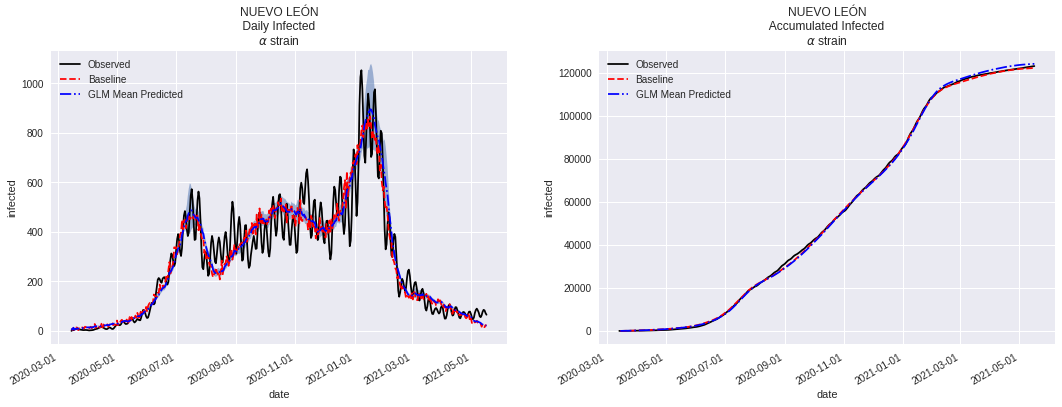

In [178]:
'''
alpha plots
'''
SOFT_PAR = 1
cs_density_baseline = inter_soft(
    days_alpha, X_baseline_alpha, SOFT_PAR)
cs_density_acc = inter_soft(
    days_alpha, X_acc_mean_alpha, SOFT_PAR)
cs_density_obs = mobile_mean(
    days_alpha,np.concatenate([[num_cum_alpha[0]],num_cum_alpha[1:]-num_cum_alpha[:-1]]), M_MEAN)

plt.figure(figsize=(18,6))


# Density
plt.subplot(1,2,1)
plt.plot_date(date_state_alpha[1:], cs_density_obs(
    days_alpha[1:]), fmt='k-', label='Observed')
plt.plot_date(date_state_alpha[1:], cs_density_baseline(days_alpha[1:]), fmt='r--', label='Baseline')
plt.plot_date(date_state_alpha[1:],cs_model_alpha(days_alpha[1:]),label='GLM Mean Predicted',fmt='b-.')
plt.fill_between(pd.to_datetime(pd.Series(date_state_alpha[1:])),cs_conf_band_alpha_mean_L(days_alpha[1:]),cs_conf_band_alpha_mean_U(days_alpha[1:]),alpha=0.5)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Accumulated 
plt.subplot(1,2,2)
plt.plot_date(date_state_alpha, num_cum_alpha, fmt='-k', label='Observed')
plt.plot_date(date_state_alpha[1:], np.cumsum(cs_density_baseline(days_alpha[1:])), fmt='r--', label='Baseline')
plt.plot_date(date_state_alpha[1:],np.cumsum(cs_model_alpha(days_alpha[1:])),label='GLM Mean Predicted',fmt='b-.')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$\alpha$ strain')
plt.xlabel('date')
plt.ylabel('infected')

And for $\Delta$ strain

Text(0, 0.5, 'infected')

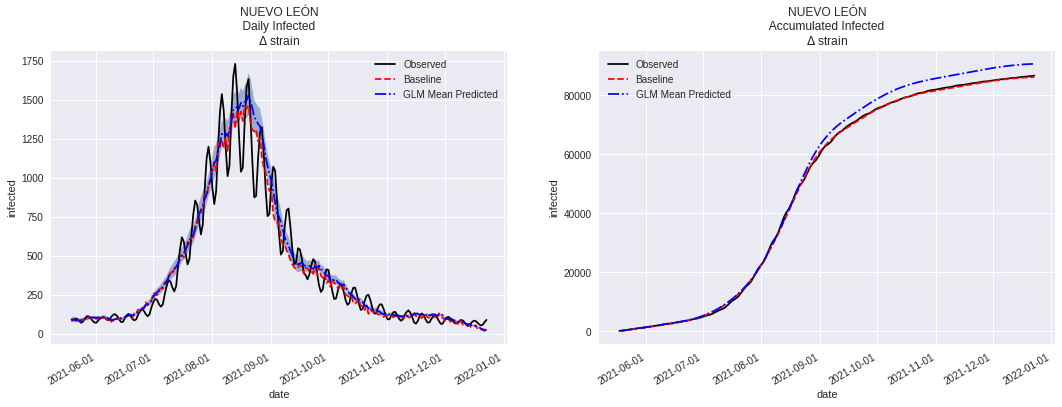

In [179]:
''' 
delta plots
'''
cs_density_baseline = inter_soft(
    days_delta, X_baseline_delta, SOFT_PAR)
cs_density_acc = inter_soft(
    days_delta, X_acc_mean_delta, SOFT_PAR)
cs_density_obs = mobile_mean(
    days_delta,np.concatenate([[num_cum_delta[0]],num_cum_delta[1:]-num_cum_delta[:-1]]), M_MEAN)

plt.figure(figsize=(18,6))

# Density
plt.subplot(1,2,1)
plt.plot_date(date_state_delta[1:], cs_density_obs(
    days_delta[1:]), fmt='k-', label='Observed')
plt.plot_date(date_state_delta[1:], cs_density_baseline(days_delta[1:]), fmt='r--', label='Baseline')
plt.plot_date(date_state_delta[1:],cs_model_delta(days_delta[1:]),label='GLM Mean Predicted',fmt='b-.')
plt.fill_between(pd.to_datetime(pd.Series(date_state_delta[1:])),cs_conf_band_delta_mean_L(days_delta[1:]),cs_conf_band_delta_mean_U(days_delta[1:]),alpha=0.5)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Accumulated
plt.subplot(1,2,2)
plt.plot_date(date_state_delta, num_cum_delta, fmt='-k', label='Observed')
plt.plot_date(date_state_delta[1:], np.cumsum(cs_density_baseline(days_delta[1:])), fmt='r--', label='Baseline')
plt.plot_date(date_state_delta[1:],np.cumsum(cs_model_delta(days_delta[1:])),label='GLM Mean Predicted',fmt='b-.')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$\Delta$ strain')
plt.xlabel('date')
plt.ylabel('infected')

Finally, for omicron strain, the result is

Text(0, 0.5, 'infected')

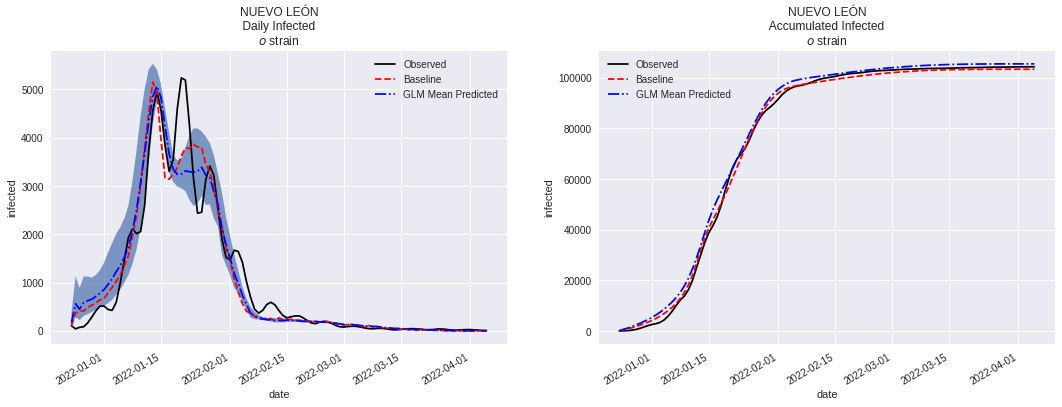

In [180]:
''' 
omicron plots
'''
cs_density_baseline = inter_soft(
    days_omicron, X_baseline_omicron, SOFT_PAR)
cs_density_acc = inter_soft(
    days_omicron, X_acc_mean_omicron, SOFT_PAR)
cs_density_obs = mobile_mean(
    days_omicron,np.concatenate([[num_cum_omicron[0]],num_cum_omicron[1:]-num_cum_omicron[:-1]]), M_MEAN)

plt.figure(figsize=(18,6))

# Density
plt.subplot(1,2,1)
plt.plot_date(date_state_omicron, cs_density_obs(
    days_omicron), fmt='k-', label='Observed')
plt.plot_date(date_state_omicron, cs_density_baseline(days_omicron), fmt='r--', label='Baseline')
plt.plot_date(date_state_omicron,cs_model_omicron(days_omicron),label='GLM Mean Predicted',fmt='b-.')
plt.fill_between(pd.to_datetime(pd.Series(date_state_omicron)),cs_conf_band_omicron_mean_L(days_omicron),cs_conf_band_omicron_mean_U(days_omicron),alpha=0.7)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Daily Infected \n'+ r'$o$ strain')
plt.xlabel('date')
plt.ylabel('infected')

# Accumulated
plt.subplot(1,2,2)
plt.plot_date(date_state_omicron, num_cum_omicron, fmt='-k', label='Observed')
plt.plot_date(date_state_omicron, np.cumsum(cs_density_baseline(days_omicron)), fmt='r--', label='Baseline')
plt.plot_date(date_state_omicron,np.cumsum(cs_model_omicron(days_omicron)),label='GLM Mean Predicted',fmt='b-.')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Accumulated Infected \n'+ r'$o$ strain')
plt.xlabel('date')
plt.ylabel('infected')

### Total

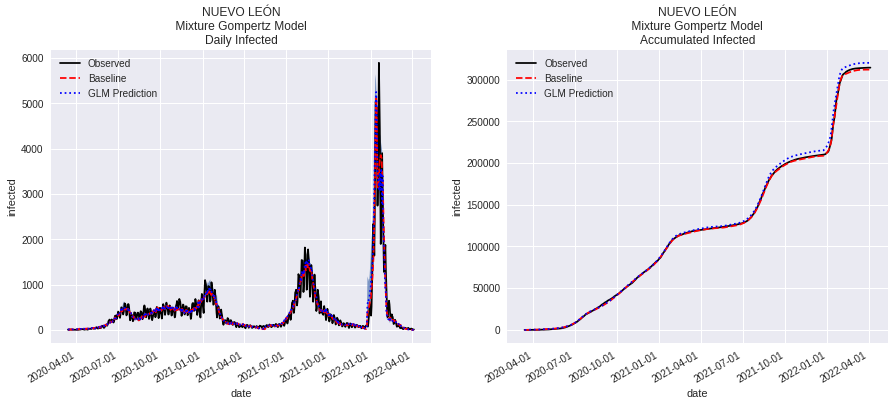

In [181]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)

plt.plot_date(date_total,cs_num_dia_total(days_total), fmt='k-', label='Observed')
plt.plot_date(date_total,X_baseline_total, fmt='r--', label='Baseline')
plt.plot_date(date_total,X_acc_model, fmt='b:', label='GLM Prediction')
plt.fill_between(date_total,X_acc_model_L,X_acc_model_U,alpha=0.7)


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Mixture Gompertz Model \nDaily Infected')
plt.xlabel('date')
plt.ylabel('infected')

plt.subplot(1,2,2)

plt.plot_date(date_total,cs_num_cum_total(days_total), fmt='k-', label='Observed')
plt.plot_date(date_total,A_baseline_total, fmt='r--', label='Baseline')
plt.plot_date(date_total,A_acc_model, fmt='b:', label='GLM Prediction')
#plt.fill_between(date_total,A_acc_model_L,A_acc_model_U,alpha=0.3)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Mixture Gompertz Model \nAccumulated Infected')
plt.xlabel('date')
plt.ylabel('infected')

plt.show()

## Gompertz growth model

We are going to get the motivation plots. First, we obtain a sample

In [182]:
'''
Sample of each version
'''
G_sample = g_sample(df_state_for_proof, SamplesDir +
                       state_for_proof+'_v1.csv', SAMPLES, M_MEAN)
G_sample.main()
df_sample = G_sample.get_sampling_data()
df_sample['Rt'] = cs_rt(df_sample.tiempo.to_numpy())

Afterwards, we get growth model that we are looking for generalization.

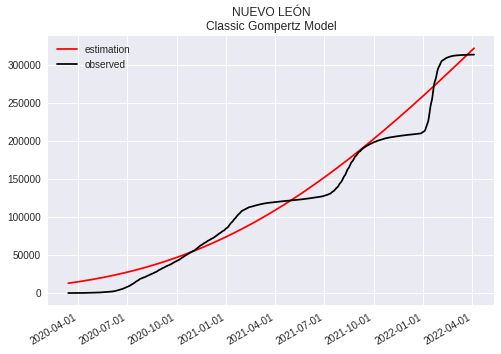

In [183]:
importlib.reload(initial_conditions)
from initial_conditions import gompertz_growth,neg_gomp_IC

G = [1]
data_sample_state = df_sample.copy()
data_state = df_state_for_proof.copy()
par_gomp_state_for_proof = neg_gomp_IC(
    G, data_state, data_sample_state, pob)[0]
par_gomp_state_for_proof['beta'] = np.exp(
    par_gomp_state_for_proof['gamma'])/par_gomp_state_for_proof['kappa']

plt.plot_date(date_total, gompertz_growth(par_gomp_state_for_proof,
                                     days_total), label='estimation',fmt='r-')
plt.plot_date(date_total, cs_num_cum_total(days_total), label='observed', fmt='k-')
plt.title(f'{state_for_proof}\nClassic Gompertz Model')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

Then, we show the daily infected curve for classic Gompertz model

In [184]:
range_cepas_dates

[Timestamp('2020-03-02 00:00:00'),
 Timestamp('2021-05-18 00:00:00'),
 Timestamp('2021-12-23 00:00:00')]

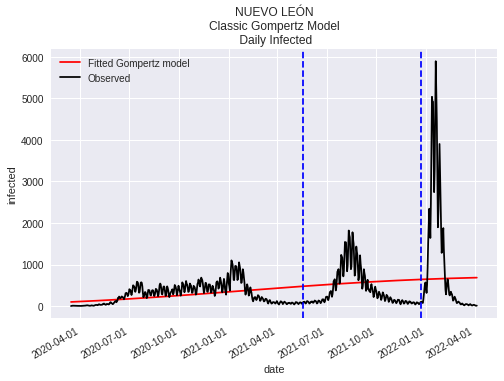

In [185]:
f=plt.figure()
plt.plot_date(date_total[1:], gompertz_growth(par_gomp_state_for_proof, days_total)[
         1:]-gompertz_growth(par_gomp_state_for_proof, days_total)[:-1], label='Fitted Gompertz model', fmt='r-')
plt.plot_date(date_total[1:], cs_num_dia_total(days_total[1:]), label='Observed', fmt='k-')
plt.axvline(x = range_cepas_dates[1],color='blue',linestyle='dashed')
plt.axvline(x = range_cepas_dates[2],color='blue',linestyle='dashed')
plt.title(f'{state_for_proof}\nClassic Gompertz Model\n Daily Infected')
plt.legend()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel('date')
plt.ylabel('infected')
# Color EPS and PNG
f.savefig(ImageDir+'density_gompertz_model.png')
f.savefig(ImageDir+'density_gompertz_model.pdf')

f.set_rasterized(True)
f.savefig(ImageDir+'density_gompertz_model.eps',rasterized=True,dpi=300)

# Gray PNG
img = Image.open(ImageDir+'density_gompertz_model.png').convert('LA')
img.save(ImageDir+'density_gompertz_model_gray.png')

# Gray EPS
img = Image.open(ImageDir+'density_gompertz_model.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'density_gompertz_model_gray.eps')
plt.show()

## Useful results

Here we show some information that we got. First, we show the known $R_t$ range

In [186]:
range_dates_rt

(Timestamp('2020-03-02 00:00:00'), Timestamp('2022-01-23 00:00:00'))

Then, we show the carrying capacity of each process, fraction of susceptible population and total susceptible population deemed at the beginning of each strain.

In [187]:
# por cepa base

print("P_r alpha = %.4f, k_r = %.4f, alpha_k = %.4f" %(P_alpha,k_alpha,P_alpha/k_alpha))
print("P_r delta = %.4f, k_r = %.4f, alpha_k = %.4f" %(P_delta,k_delta,P_delta/k_delta))
print("P_r omicron = %.4f, k_r = %.4f, alpha_k = %.4f" %(P_omicron,k_omicron,P_omicron/k_omicron))

P_r alpha = 4653458.0000, k_r = 37.9544, alpha_k = 122606.4375
P_r delta = 4653458.0000, k_r = 53.8238, alpha_k = 86457.2338
P_r omicron = 4653458.0000, k_r = 45.0063, alpha_k = 103395.7832


Total population is

In [188]:
print(f'{state_for_proof} population: {pob}')

NUEVO LEÓN population: 4653458.0


Last day observed

In [189]:
date_total[-1]

Timestamp('2022-04-05 00:00:00')

Accumulated number observed

In [190]:
print('Total accumulated alpha ',df_state_for_proof_alpha.iloc[-1]['CasosAcumulados'])
print('Total accumulated delta ',df_state_for_proof_delta.iloc[-1]['CasosAcumulados'])
print('Total accumulated omicron ',df_state_for_proof_omicron.iloc[-1]['CasosAcumulados'])

Total accumulated alpha  123301.0
Total accumulated delta  86755.0
Total accumulated omicron  104258.0


## Projection

We show an example of Gompertz tail estimation in order to complete that and do all the calculation presented.

We analyze $\Omicron$ strain case.

For using `Peaks-overs threshold method`, we need to smooth general sample dataset. We use a nonparametric method: Kernel Density estimation

In [191]:
importlib.reload(samples)
from samples import kde_sample

PATH_KDE_SAMPLE_OMICRON=SamplesDir+state_for_proof+'_kde_sample_omicron.csv'

kde_omicron=kde_sample(df_sample_omicron,PATH_KDE_SAMPLE_OMICRON,50000)
kde_omicron.main()

We estimate tail parameters with truncated smoothed sample

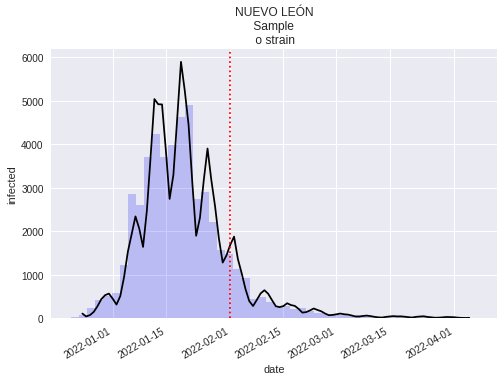

In [192]:
df_sample_kde_omicron=pd.read_csv(PATH_KDE_SAMPLE_OMICRON)
trun_par=int(num_umbral_date-num_omicron_rt_begin)
df_sample_kde_omicron_trun=df_sample_kde_omicron[df_sample_kde_omicron.tiempo<trun_par]
df_sample_kde_omicron_trun.to_csv(SamplesDir+state_for_proof+'_kde_sample_omicron_trun.csv')

'''
To date
'''
# Sample in date
sample_date_omicron_kde=[]
sample_num_kde_omicron=df_sample_kde_omicron.tiempo.to_numpy()
for i in range(len(sample_num_kde_omicron)):
    sample_date_omicron_kde.append(range_cepas_dates[2]+timedelta(days=int(sample_num_kde_omicron[i])))

# Visualization
plt.style.use('seaborn')
f=plt.figure()
plt.plot_date(df_state_for_proof_omicron.Fecha,G_sample_omicron.num_dia_mean,fmt='k-')
plt.hist(sample_date_omicron_kde,
         orientation='vertical', alpha=0.2, bins=50, color='b')
plt.axvline(umbral_date,linestyle='dotted',color='red')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.title(f'{state_for_proof}\n Sample \n o strain')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.savefig(ImageDir+'kde_sample_omicron.png')
f.savefig(ImageDir+'kde_sample_omicron.pdf')
f.set_rasterized(True)
f.savefig(ImageDir+'kde_sample_omicron.eps',rasterized=True,dpi=300)

# Gray PNG
img = Image.open(ImageDir+'kde_sample_omicron.png').convert('LA')
img.save(ImageDir+'kde_sample_omicron_gray.png')

# Gray EPS
img = Image.open(ImageDir+'kde_sample_omicron.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'kde_sample_omicron_gray.eps')
plt.show()

We estimate Pareto-generalized parameters 

In [193]:
'''
Parametros ajustados para la DGP
'''
p_pareto=[14.0140216, -0.7354553]

'''
Umbral seleccionado
'''
u= 30

'''
Susceptibles
'''
S0=P_omicron


num_dia_omicron_trun=G_sample_omicron.num_dia_mean[:trun_par]
num_cum_omicron_trun=G_sample_omicron.num_cum_mean[:trun_par]
days_omicron_trun=days_omicron[:trun_par]


# Indice con el el valor u para el dia
day_final=days_omicron[-1]

Finally, we present the tail estimation and we contrast with observed data

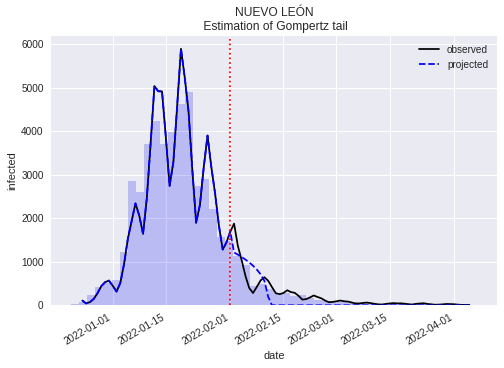

In [194]:
from scipy.stats import genpareto

'''
Proyeccion de los infectados
'''

# Supervivencia
sf_general_omicron,sf_comp_omicron=MG_baseline_omicron.sf(days_omicron)

def projection(trun_par,day_final):
    t=np.arange(trun_par-u,day_final-u)
    d_pareto=genpareto.pdf(t,c=p_pareto[1],scale=p_pareto[0])
    sf_u=1.0-(G_sample_omicron.num_cum[u]/(P_omicron/k_omicron))
    infected_pro=G_sample_omicron.num_cum[u]*sf_u*d_pareto
    num_dia_omicron_proj=np.concatenate((num_dia_omicron_trun,infected_pro))
    return num_dia_omicron_proj

num_dia_omicron_trun_proj=projection(trun_par,day_final)

'''
Visualización de la proyeccion vs los observados
'''
f=plt.figure()
plt.plot_date(date_state_omicron,G_sample_omicron.num_dia_mean,fmt='k-',label='observed')
plt.plot_date(date_state_omicron,num_dia_omicron_trun_proj,fmt='b--',label='projected')
plt.hist(sample_date_omicron_kde,orientation='vertical', alpha=0.2, bins=50, color='b')
plt.axvline(umbral_date,linestyle='dotted',color='red')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend()
plt.title(f'{state_for_proof}\n Estimation of Gompertz tail')
plt.xlabel('date')
plt.ylabel('infected')

# Color EPS and PNG
f.savefig(ImageDir+'tail_gompertz_model.pdf')
f.savefig(ImageDir+'tail_gompertz_model.png')
f.set_rasterized(True)
f.savefig(ImageDir+'tail_gompertz_model.eps',rasterized=True,dpi=300)


# Gray PNG
img = Image.open(ImageDir+'tail_gompertz_model.png').convert('LA')
img.save(ImageDir+'tail_gompertz_model_gray.png')

# Gray EPS
img = Image.open(ImageDir+'tail_gompertz_model.eps')
img.load(scale=4)   
img.convert("L").save(ImageDir+'tail_gompertz_model_gray.eps')
plt.show()